# Query Decomposition

In [ ]:
from openai import OpenAI
import pandas as pd
import time

# Set DeepSeek API key securely
client = OpenAI(api_key=API_KEY, base_url="https://api.deepseek.com")

# Define the prompt template as a standalone variable
PROMPT_TEMPLATE = '''
Role:
You are a helpful assistant that specializes in decomposing complex questions {Question} into smaller, manageable sub-questions.

Instruction:
Given an input question, break it down into related sub-questions or sub-problems that could be addressed independently. Each sub-question should be phrased as a search query to help guide further research or exploration.

Output Requirements:
Generate 5 relevant and distinct search queries based on the input question. Output each query as a separate line, without numbering or quotation marks.

'''

def get_deepseek_response(question):
    prompt = PROMPT_TEMPLATE.format(Question=question)  # Fill the placeholder with the actual question
    retries = 5  # Maximum retries
    for i in range(retries):
        try:
            response = client.chat.completions.create(
                model="deepseek-chat",
                messages=[{"role": "user", "content": prompt}],
                max_tokens=300
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            time.sleep(2 ** i + 1)  # Exponential backoff
    return "[API Error: Maximum retries exceeded]"

# Define file paths
input_filename = "../data/MSE-KG/KG_QA/Competency_Question.xlsx"  # Input file path
output_filename = "../data/MSE-KG/BGEM3/Competency_Question_QD_BGEM3.xlsx"  # Output file path

# Read the Excel file
question_df = pd.read_excel(input_filename)

# Strip any leading/trailing spaces from the column names
question_df.columns = question_df.columns.str.strip()

# Print the columns to verify
print("Columns in the file:", question_df.columns)

# Iterate over each question and apply the DP response function
auxiliary_queries = []  # Changed from simplified_phrases to auxiliary_queries
print("Processing questions... This may take some time.")
for idx, question in enumerate(question_df['Competency Question']):
    print(f"\nProcessing Question {idx + 1}: {question}")
    auxiliary_query = get_deepseek_response(question)
    print(f"Generated Queries:\n{auxiliary_query}")
    auxiliary_queries.append(auxiliary_query)


# Add the DP responses to the dataframe
question_df['Auxiliary Queries'] = auxiliary_queries  # Changed from Simplified Phrases to Auxiliary Queries

# Save the results to a new Excel file
question_df.to_excel(output_filename, index=False)
print(f"Processed data saved to: {output_filename}")


Columns in the file: Index(['Competency Question', 'Ground Truth'], dtype='object')
Processing questions... This may take some time.

Processing Question 1: Who is working in the Computational Materials Science field?
Generated Queries:
Who are the leading researchers in Computational Materials Science?  
What are the key institutions or universities known for Computational Materials Science research?  
Which industries employ professionals in Computational Materials Science?  
What are the common job titles or roles for professionals in Computational Materials Science?  
What recent breakthroughs or publications highlight prominent figures in Computational Materials Science?

Processing Question 2: What are the research projects associated to EMMO?
Generated Queries:
What is EMMO and its primary research focus?  
List current research projects under the EMMO framework.  
Which institutions or organizations are involved in EMMO-related research?  
What are the key publications or paper


 # BGE-M3 Retrieval 

In [4]:
import pandas as pd
import numpy as np
import faiss
from langchain.schema import Document
from sentence_transformers import SentenceTransformer
from FlagEmbedding import FlagModel

class FaissRetriever:
    def __init__(self, documents, model_name="BAAI/bge-m3"):
        """
        Initialize FAISS retriever with documents and embedding model.
        Automatically filter, encode, and index documents.
        """
        # Filter and prepare documents
        self.documents = [Document(page_content=line.strip(), metadata={"id": idx}) 
                          for idx, line in enumerate(documents) if len(line.strip()) > 5]
        
        # Initialize embedding model
        self.model = SentenceTransformer(model_name)
        
        # Generate and normalize embeddings
        text_contents = [doc.page_content for doc in self.documents]
        embeddings = self.model.encode(text_contents, convert_to_tensor=False)
        self.embeddings = np.array(embeddings).astype("float32")
        faiss.normalize_L2(self.embeddings)

        # Build FAISS index
        self.index = faiss.IndexFlatIP(self.embeddings.shape[1])
        self.index.add(self.embeddings)

    def GetFaissTopK(self, query, topk):
        """
        Retrieve top-k most relevant documents with similarity scores.
        Returns: List[Document] with scores in metadata.
        """
        # Generate and normalize query embedding
        query_embedding = self.model.encode([query], convert_to_tensor=False)
        query_embedding = np.array(query_embedding).astype("float32")
        faiss.normalize_L2(query_embedding)

        valid_topk = min(topk, len(self.documents))
        scores, indices = self.index.search(query_embedding, valid_topk)

        # Return results with scores
        results = []
        for idx, score in zip(indices[0], scores[0]):
            original_doc = self.documents[idx]
            new_metadata = original_doc.metadata.copy()
            new_metadata["score"] = float(score)
            results.append(Document(
                page_content=original_doc.page_content,
                metadata=new_metadata
            ))
        return results

# File paths
TEXT_FILE_PATH = "../data/MSE-KG/KGPreprocess/verbalized_triples_np.txt"
EXCEL_FILE_PATH = "../data/MSE-KG/BGEM3/Competency_Question_QD_BGEM3.xlsx"

# Load documents
with open(TEXT_FILE_PATH, "r", encoding="utf-8") as file:
    document_lines = file.readlines()

# Initialize FAISS retriever
faiss_retriever = FaissRetriever(document_lines)

# Load Excel file
df = pd.read_excel(EXCEL_FILE_PATH)
competency_questions = df["Competency Question"].tolist()

# Create result DataFrame
result_df = df.copy()

# Process different top_k values
for top_k in range(10, 101, 10):
    print(f"\nProcessing with top_k={top_k}...")
    
    # Process main competency questions
    main_results = []
    for question in competency_questions:
        docs = faiss_retriever.GetFaissTopK(question, top_k)
        main_results.append(docs)
    
    # Process auxiliary queries (5 decomposed questions)
    auxiliary_results = []
    for query in df["Auxiliary Queries"]:
        elements = [elem.strip() for elem in query.split("\n") if elem.strip()]
        if len(elements) < 5:
            auxiliary_results.append([])
            continue
            
        # Decompose into 5 sub-queries
        sub_queries = elements[:5]
        combined_docs = []
        
        # Retrieve results for each sub-query
        for sub_q in sub_queries:
            docs = faiss_retriever.GetFaissTopK(sub_q, top_k)
            combined_docs.extend(docs)
        
        auxiliary_results.append(combined_docs)
    
    # Merge main and auxiliary results
    merged_results = []
    for main, aux in zip(main_results, auxiliary_results):
        # Combine and deduplicate documents (keep the highest score for duplicates)
        combined_docs = {}
        for doc in main + aux:
            content = doc.page_content
            score = doc.metadata["score"]
            if content not in combined_docs or combined_docs[content]["score"] < score:
                combined_docs[content] = {"content": content, "score": score}
        
        # Sort by relevance score (descending)
        sorted_docs = sorted(combined_docs.values(), key=lambda x: x["score"], reverse=True)
        
        # Format results with content and score
        merged_results.append(" | ".join([
            f"{doc['content']} ({doc['score']:.3f})" for doc in sorted_docs
        ]))
    
    # Add merged results to DataFrame
    result_df[f"FAISS_TopK_{top_k}"] = merged_results
    
    # Final consolidation for the current top_k
    final_df = pd.DataFrame({
        "Competency Question": df["Competency Question"],
        "Ground Truth": df["Ground Truth"],
        "Auxiliary Queries": df["Auxiliary Queries"],
        "Contexts": result_df[f"FAISS_TopK_{top_k}"]
    })

    # Define the final output file path with the new naming convention
    final_output_path = f"../data/MSE-KG/BGEM3/Contexts_by_BGE_M3_5Decom_{top_k}.xlsx"
    
    # Save the final DataFrame to an Excel file
    final_df.to_excel(final_output_path, index=False)
    print(f"Final results for top_k={top_k} saved to {final_output_path}")

print("All processing completed.")


Processing with top_k=10...
Final results for top_k=10 saved to ../data/MSE-KG/BGEM3/ontexts_by_BGE_M3_5Decom_10.xlsx

Processing with top_k=20...
Final results for top_k=20 saved to ../data/MSE-KG/BGEM3/ontexts_by_BGE_M3_5Decom_20.xlsx

Processing with top_k=30...
Final results for top_k=30 saved to ../data/MSE-KG/BGEM3/ontexts_by_BGE_M3_5Decom_30.xlsx

Processing with top_k=40...
Final results for top_k=40 saved to ../data/MSE-KG/BGEM3/ontexts_by_BGE_M3_5Decom_40.xlsx

Processing with top_k=50...
Final results for top_k=50 saved to ../data/MSE-KG/BGEM3/ontexts_by_BGE_M3_5Decom_50.xlsx

Processing with top_k=60...
Final results for top_k=60 saved to ../data/MSE-KG/BGEM3/ontexts_by_BGE_M3_5Decom_60.xlsx

Processing with top_k=70...
Final results for top_k=70 saved to ../data/MSE-KG/BGEM3/ontexts_by_BGE_M3_5Decom_70.xlsx

Processing with top_k=80...
Final results for top_k=80 saved to ../data/MSE-KG/BGEM3/ontexts_by_BGE_M3_5Decom_80.xlsx

Processing with top_k=90...
Final results for t

In [8]:
import re
import os
from openpyxl import load_workbook

def clean_contexts(file_path):
    """Clean context data by removing confidence scores and replacing pipes with newlines"""
    # Load Excel file
    wb = load_workbook(filename=file_path)
    ws = wb.active
    
    # Process all cells
    for row in ws.iter_rows():
        for cell in row:
            if cell.value and isinstance(cell.value, str):
                # Replace pipes with newlines
                cleaned_value = cell.value.replace('|', '\n')
                
                # Remove confidence scores (0.xxx)
                cleaned_value = re.sub(r'\s*\(\d+\.\d+\)', '', cleaned_value)
                
                # Update cell value
                cell.value = cleaned_value.strip()  # Remove any extra whitespace
    
    # Save cleaned file
    new_file_path = file_path.replace('.xlsx', '_cleaned.xlsx')
    wb.save(new_file_path)
    print(f"Successfully cleaned and saved: {new_file_path}")

# Directory containing files
base_dir = "../data/MSE-KG/BGEM3/"

# Process files for top_k values from 10 to 100 (in steps of 10)
for top_k in range(10, 101, 10):
    file_name = f"Contexts_by_BGE_M3_5Decom_{top_k}.xlsx"
    file_path = os.path.join(base_dir, file_name)
    
    if os.path.exists(file_path):
        clean_contexts(file_path)
    else:
        print(f"Warning: File not found - {file_path}")

print("All files processed successfully.")

Successfully cleaned and saved: ../data/MSE-KG/BGEM3/Contexts_by_BGE_M3_5Decom_10_cleaned.xlsx
Successfully cleaned and saved: ../data/MSE-KG/BGEM3/Contexts_by_BGE_M3_5Decom_20_cleaned.xlsx
Successfully cleaned and saved: ../data/MSE-KG/BGEM3/Contexts_by_BGE_M3_5Decom_30_cleaned.xlsx
Successfully cleaned and saved: ../data/MSE-KG/BGEM3/Contexts_by_BGE_M3_5Decom_40_cleaned.xlsx
Successfully cleaned and saved: ../data/MSE-KG/BGEM3/Contexts_by_BGE_M3_5Decom_50_cleaned.xlsx
Successfully cleaned and saved: ../data/MSE-KG/BGEM3/Contexts_by_BGE_M3_5Decom_60_cleaned.xlsx
Successfully cleaned and saved: ../data/MSE-KG/BGEM3/Contexts_by_BGE_M3_5Decom_70_cleaned.xlsx
Successfully cleaned and saved: ../data/MSE-KG/BGEM3/Contexts_by_BGE_M3_5Decom_80_cleaned.xlsx
Successfully cleaned and saved: ../data/MSE-KG/BGEM3/Contexts_by_BGE_M3_5Decom_90_cleaned.xlsx
Successfully cleaned and saved: ../data/MSE-KG/BGEM3/Contexts_by_BGE_M3_5Decom_100_cleaned.xlsx
All files processed successfully.


# Generation

In [12]:
# Generation Prompt Update
GENERATION_PROMPT_TEMPLATE = '''
Given the following question and combined factual contexts from two sources (triples and text):

Question: {question}
Context(s): {contexts}

Instructions:
1. Use Contexts Effectively: While the contexts provide information, they may contain redundancy. Focus on the most relevant triples that directly answer the question.
2. Leverage Understanding: Utilize your ability to comprehend and deduce the most essential details, even if some triples are less relevant or repetitive.
3. Direct Answers: Provide answers in a list format of phrases if appropriate, without any introductory phrases or complete sentences. Only provide the key facts.
4. Avoid Irrelevant Details: Omit information that does not directly contribute to answering the question.
5. List Format: When listing items, separate them with semicolons (;) instead of using dashes (-) or other symbols.
6. No Prefixes: Do not include any introductory phrases like "Based on the provided contexts" or "Answer:".
7. No Answer Indication: If no relevant information is found, simply return "(No Answer)" without any additional explanation.

Examples:
Question: Who was the first president of the United States?
Contexts:
George Washington was the first president of the United States.
George Washington took office in 1789.
George Washington won both presidential elections.

Answer:
George Washington
'''

In [ ]:
from openai import OpenAI
import pandas as pd
import time
import os
from tqdm import tqdm

# Configuration Constants
BASE_URL = "https://api.deepseek.com"
MODEL_NAME = "deepseek-chat"
MAX_TOKENS = 1000
RETRY_COUNT = 3
SLEEP_INTERVAL = 1  # Rate limiting between API calls
DATA_DIR = "../data/MSE-KG/BGEM3/"

client = OpenAI(api_key=API_KEY, base_url=BASE_URL)

def generate_answer(question: str, context: str) -> str:
    """Generates answer using OpenAI API with retry mechanism."""
    if not context.strip():
        return "[No Answer]"

    prompt = GENERATION_PROMPT_TEMPLATE.format(question=question, contexts=context)
    
    for attempt in range(RETRY_COUNT):
        try:
            response = client.chat.completions.create(
                model=MODEL_NAME,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=MAX_TOKENS
            )
            answer = response.choices[0].message.content.strip()
            print(f"\nGenerated Answer:\n{answer}\n")  # Print the generated answer
            return answer
        except Exception as e:
            print(f"API error (Attempt {attempt+1}/{RETRY_COUNT}): {str(e)}")
            time.sleep(2 ** attempt)  # Exponential backoff
    return "[API Error: Maximum retries exceeded]"

def process_questions(df: pd.DataFrame, context_column: str) -> tuple[list, list]:
    """Processes dataframe rows and generates answers."""
    answers = []
    failed_indices = []

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating Answers"):
        try:
            question = str(row.get('Competency Question', ''))
            context = str(row.get(context_column, ''))
            
            print(f"\nProcessing Question {index+1}: {question}")
            
            answer = generate_answer(question, context)
            answers.append(answer)

            time.sleep(SLEEP_INTERVAL)  # Global rate limiting
        except Exception as e:
            print(f"Row {index} failed: {str(e)}")
            answers.append("[Error]")
            failed_indices.append(index)

    return answers, failed_indices

def process_single_file(input_path, output_path, top_k):
    try:
        df = pd.read_excel(input_path)
        
        # Get the correct context column name
        context_column = f"Contexts"
        
        if context_column not in df.columns:
            raise ValueError(f"Column {context_column} not found in the input file")
        
        answers, failed = process_questions(df, context_column)

        df['Answer'] = answers
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        df.to_excel(output_path, index=False)
        
        print(f"\n[✓] Saved: {output_path}")
        if failed:
            print(f"[-] {len(failed)} rows failed in {input_path}")

    except Exception as e:
        print(f"[X] Error with file {input_path}: {str(e)}")

if __name__ == "__main__":
    for top_k in range(10, 101, 10):
        input_path = f"{DATA_DIR}Contexts_by_BGE_M3_5Decom_{top_k}_cleaned.xlsx"
        output_path = f"{DATA_DIR}Predicted_Answers_Contexts_by_BGE_M3_Decom5_{top_k}.xlsx"
        process_single_file(input_path, output_path, top_k)

Generating Answers:   0%|          | 0/37 [00:00<?, ?it/s]


Processing Question 1: Who is working in the Computational Materials Science field?

Generated Answer:
Prof. Stefan Diebels; Dr Sarath Menon; Prof. Dr. Karsten Durst; Christian Dorn; Prof. Dr. Jörg Neugebauer; PD Dr. Franz Roters



Generating Answers:   3%|▎         | 1/37 [00:06<03:58,  6.63s/it]


Processing Question 2: What are the research projects associated to EMMO?

Generated Answer:
VIMMP (2018-2021); NanoMECommons (2021-2025); EMMC-CSA (2016-2019); OpenModel (2021-2025); ReaxPro (2019-2023); MarketPlace (2018-2022); SimDOME (2019-2023); OYSTER (2017-2021); OntoCommons (2020-2023); OntoTrans (2020-2024)



Generating Answers:   5%|▌         | 2/37 [00:17<05:09,  8.85s/it]


Processing Question 3: Who are the contributors of the data "datasets"?

Generated Answer:
Prof. Felix Fritzen; Frederik Larsson; Oliver Weeger; Mauricio Fernández



Generating Answers:   8%|▊         | 3/37 [00:24<04:32,  8.02s/it]


Processing Question 4: Who is working with Researcher "Ebrahim Norouzi" in the same group?

Generated Answer:
(No Answer)



Generating Answers:  11%|█         | 4/37 [00:31<04:18,  7.85s/it]


Processing Question 5: who is the email address of "ParaView"?

Generated Answer:
support@kitware.com



Generating Answers:  14%|█▎        | 5/37 [00:36<03:40,  6.90s/it]


Processing Question 6: What are the affilliations of Volker Hofmann?

Generated Answer:
Forschungszentrum Jülich



Generating Answers:  16%|█▌        | 6/37 [00:43<03:30,  6.79s/it]


Processing Question 7: What is "Molecular Dynamics" Software? List the programming language, documentation page, repository, and license information.

Generated Answer:
Visual Molecular Dynamics: programming language (No Answer); documentation page https://www.ks.uiuc.edu/Research/vmd/current/ug/; repository (No Answer); license Distribution specific, VMD Software License Agreement;  
High-Throughput Molecular Dynamics: programming language python; documentation page (No Answer); repository https://github.com/Acellera/htmd; license Vendor specific license. HTMD Software Not-for-Profit License Agreement v1.1;  
The ITAP Molecular Dynamics Program: programming language C; programming language C++; documentation page "http://imd.itap.physik.uni-stuttgart.de/userguide/imd.html"; repository https://github.com/itapmd; license GNU General Public License v3;  
Carr Parrinello Molecular Dynamics: programming language Fortran; documentation page (No Answer); repository (No Answer); license (No 

Generating Answers:  19%|█▉        | 7/37 [00:59<04:52,  9.74s/it]


Processing Question 8: What are pre- and post-processing tools for MD simulations?

Generated Answer:
Atomicrex; LAMMPS; Pyiron; Runner; Sphinx; paraview; python; OVITO; TAMkin; Atomic Simulation Environment



Generating Answers:  22%|██▏       | 8/37 [01:05<04:14,  8.77s/it]


Processing Question 9: What are some workflow environments for computational materials science?

Generated Answer:
Materials Cloud; Automated interactive infrastructure and database for computational science; Computational Autonomy for Materials Discovery; NIST Materials Data Curation System; Materials Platform for Data Science; MatNavi: NIMS Materials Database; Matbench



Generating Answers:  24%|██▍       | 9/37 [01:12<03:49,  8.20s/it]


Processing Question 10: How should I cite pyiron?

Generated Answer:
{pyiron: An integrated development environment for computational materials science}; Computational Materials Science; 163; 24 - 36; 2019; https://doi.org/10.1016/j.commatsci.2018.07.043; Jan Janssen; Sudarsan Surendralal; Yury Lysogorskiy; Mira Todorova; Tilmann Hickel; Ralf Drautz; Jörg Neugebauer



Generating Answers:  27%|██▋       | 10/37 [01:22<03:54,  8.69s/it]


Processing Question 11: Where can I find a list of interatomic potentials?

Generated Answer:
https://www.ctcms.nist.gov/potentials/; OpenKIM



Generating Answers:  30%|██▉       | 11/37 [01:28<03:24,  7.88s/it]


Processing Question 12: What are python libraries used for calculating local atomic structural environment?

Generated Answer:
Pyscal; freud; icet; GB_code



Generating Answers:  32%|███▏      | 12/37 [01:34<03:04,  7.39s/it]


Processing Question 13: What are the electronic lab notebooks available?

Generated Answer:
eLabFTW; OpenBIS



Generating Answers:  35%|███▌      | 13/37 [01:40<02:44,  6.84s/it]


Processing Question 14: What are the software for Molecular Dynamics (MD)?

Generated Answer:
GROMACS; LAMMPS; Visual Molecular Dynamics; Carr Parrinello Molecular Dynamics; MD++; Simulation Environment for Atomistic and Molecular Modeling; High-Throughput Molecular Dynamics; The ITAP Molecular Dynamics Program; CP2K; Cluster Expansion in Atomic Simulation Environment; Atomic Simulation Recipes; Calphy



Generating Answers:  38%|███▊      | 14/37 [01:48<02:44,  7.17s/it]


Processing Question 15: What are the ontologies in nanomaterials domain?

Generated Answer:
MaterialsMine (MM); NanoParticle Ontology for Cancer Nanotechnology Research (NPO); eNanoMapper ontology; MatWerk ontology; Aditive Manufacturing Ontology (AMONTOLOGY); Material Science and Engineering Ontology (MSEO); Materials And Molecules Basic Ontology (MAMBO); Unified ontology for matrix-inclusion microstructure and composites; dislocation-ontology; Materials-Design-Ontology; Elemental Multiperspective Material Ontology (EMMO)



Generating Answers:  41%|████      | 15/37 [01:58<02:55,  7.97s/it]


Processing Question 16: What is DAMASK?

Generated Answer:
Dusseldorf Advanced Material Simulation Kit; unified multi-physics crystal plasticity simulation package; solves continuum mechanical boundary value problems; handles multi-physics problems; uses crystal plasticity method; has repository https://github.com/eisenforschung/damask; has documentation https://damask.mpie.de/documentation/index.html; has website https://damask.mpie.de/; has contact point damask@mpie.de



Generating Answers:  43%|████▎     | 16/37 [02:08<02:58,  8.51s/it]


Processing Question 17: What are the data portals for materials science ontologies?

Generated Answer:
Materials Platform for Data Science; MaterialsProject; The Open Quantum Materials Database; Materials Commons; Open Materials Database; Topological Material Database; Inorganic Material Database (AtomWork); Organic Materials Database (OMDB); The Materials Data Facility (MDF); Atomistica



Generating Answers:  46%|████▌     | 17/37 [02:14<02:40,  8.00s/it]


Processing Question 18: What are the instruments for APT?

Generated Answer:
Paraprobe-toolbox; pyiron; Jupyter lab; CompositionSpace; Pyiron; python3.9; Paraprobe-toolbox



Generating Answers:  49%|████▊     | 18/37 [02:21<02:25,  7.67s/it]


Processing Question 19: In which institution can I find tomography equipment?

Generated Answer:
Universität Stuttgart; TU Kaiserslautern; Technische Universität Darmstadt; RWTH Aachen University; Universität Paderborn; Technische Universität Clausthal; Karlsruher Institut für Technologie



Generating Answers:  51%|█████▏    | 19/37 [02:29<02:16,  7.56s/it]


Processing Question 20: What are the educational resources for Ontology?

Generated Answer:
Computational Material Sample Ontology; MatPortal; Material Science and Engineering Ontology (MSEO); Aditive Manufacturing Ontology (AMONTOLOGY); The MatWerk ontology; Materials And Molecules Basic Ontology (MAMBO); MatOnto-Ontologies; Ontologies for Materials Science; MSE Ontology education and training



Generating Answers:  54%|█████▍    | 20/37 [02:37<02:10,  7.70s/it]


Processing Question 21: What is the API of Materials Project?

Generated Answer:
Materials Project API is a software; Materials Project API has documentation https://api.materialsproject.org/docs



Generating Answers:  57%|█████▋    | 21/37 [02:42<01:50,  6.91s/it]


Processing Question 22: Which simulation software have a python API?

Generated Answer:
Atomic Simulation Environment; Atomic Simulation Recipes; Multiphysics Object Oriented Simulation Environment; DynaPhoPy



Generating Answers:  59%|█████▉    | 22/37 [02:48<01:40,  6.71s/it]


Processing Question 23: What is the documentation of the "MatDB Online"?

Generated Answer:
https://publications.jrc.ec.europa.eu/repository/handle/JRC75978



Generating Answers:  62%|██████▏   | 23/37 [02:54<01:29,  6.39s/it]


Processing Question 24: What are the types of software licenses?

Generated Answer:
Proprietary license; Academic license; no license file; OSI-approved BSD 3-clause License; Commercial license; Apache Licence, Version 2.0; No license; GPLv3+; https://creativecommons.org/licenses/by/4.0/; GPL-2.0 license; Apache license; GPL 3; public domain; MpCCI License Agreement; partly propietary; GPL-3.0 license; Qhull license; Apache-2.0 license; https://creativecommons.org/publicdomain/zero/1.0/



Generating Answers:  65%|██████▍   | 24/37 [03:04<01:36,  7.45s/it]


Processing Question 25: What are the software used to produce the data in the Materials Cloud repository?

Generated Answer:
Computational Autonomy for Materials Discovery; Open source package for Material eXplorer; Automated interactive infrastructure and database for computational science; CP2K; Simulation Environment for Atomistic and Molecular Modeling; Graphical Interface for Materials Simulations; LAMMPS; pymatgen; AiiDA



Generating Answers:  68%|██████▊   | 25/37 [03:11<01:30,  7.52s/it]


Processing Question 26: What are datasets produced by the BAM organization?

Generated Answer:
Aluminum Elastic Modulus; BAM Dataset: Creating FDO for MatWerk



Generating Answers:  70%|███████   | 26/37 [03:18<01:20,  7.33s/it]


Processing Question 27: What are some available datasets of mechanical properties of steels?

Generated Answer:
Full dataset of several mechanical tests on an S355 steel sheet as reference data for digital representations (https://doi.org/10.5281/zenodo.6778336); Metallic Material Database (Kinzoku); MatDat; Thermophysical Property Database



Generating Answers:  73%|███████▎  | 27/37 [03:27<01:17,  7.79s/it]


Processing Question 28: What are datasets related to "Transmission electron microscopy"?

Generated Answer:
Datasets for the analysis of dislocations at grain boundaries and during vein formation in cyclically deformed Ni micropillars; Radii of S-phase Al2CuMg in Al-alloy EN AW-2618A after different aging times at 190°C; Aluminum Elastic Modulus; Elastic Constant Demo Data



Generating Answers:  76%|███████▌  | 28/37 [03:34<01:09,  7.68s/it]


Processing Question 29: What is the license of the dataset "Elastic Constant Demo Data"?

Generated Answer:
BSD 3-Clause License



Generating Answers:  78%|███████▊  | 29/37 [03:40<00:55,  6.99s/it]


Processing Question 30: What is the repository for "BAM reference data"?

Generated Answer:
https://doi.org/10.5281/zenodo.5106606



Generating Answers:  81%|████████  | 30/37 [03:45<00:44,  6.36s/it]


Processing Question 31: What are the different data formats in the "BAM reference data"?

Generated Answer:
csv; pdf; .json



Generating Answers:  84%|████████▍ | 31/37 [03:50<00:37,  6.21s/it]


Processing Question 32: What is the software version of "pacemaker"?

Generated Answer:
0.2.7



Generating Answers:  86%|████████▋ | 32/37 [03:56<00:30,  6.13s/it]


Processing Question 33: What is the field of research "BAM reference data"?

Generated Answer:
Answer:
results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; compilation of test results; test data; includes specimens; has creator Prof. Birgit Skrotzki; has datePublished 7/15/2021; has repository https://doi.org/10.5281/zenodo.5106606



Generating Answers:  89%|████████▉ | 33/37 [04:05<00:27,  6.79s/it]


Processing Question 34: What is the description of the "BAM reference data"?

Generated Answer:
results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; dataset; test data; compilation of test results; includes specimens; has file extension csv; has file extension pdf; has datePublished 7/15/2021; has creator Prof. Birgit Skrotzki; has license Creative Commons Attribution 4.0 International; has repository https://doi.org/10.5281/zenodo.5106606



Generating Answers:  92%|█████████▏| 34/37 [04:15<00:23,  7.90s/it]


Processing Question 35: What are the datasets produced in 2022?

Generated Answer:
Metadata schemes for materials science data; Thermo-Calc version 2022b; GROMACS version 2022



Generating Answers:  95%|█████████▍| 35/37 [04:21<00:14,  7.36s/it]


Processing Question 36: Who is the creators of the "BAM reference data"?

Generated Answer:
Prof. Birgit Skrotzki; Sina Schriever



Generating Answers:  97%|█████████▋| 36/37 [04:28<00:07,  7.13s/it]


Processing Question 37: What are the datasets published by "BAM"?

Generated Answer:
BAM Dataset: Creating FDO for MatWerk; Aluminum Elastic Modulus; Elastic Constant Demo Data



Generating Answers: 100%|██████████| 37/37 [04:36<00:00,  7.47s/it]



[✓] Saved: ../data/MSE-KG/BGEM3/Predicted_Answers_Contexts_by_BGE_M3_Decom5_10.xlsx


Generating Answers:   0%|          | 0/37 [00:00<?, ?it/s]


Processing Question 1: Who is working in the Computational Materials Science field?

Generated Answer:
Prof. Stefan Diebels; Dr Sarath Menon; Prof. Dr. Karsten Durst; Christian Dorn; Prof. Dr. Jörg Neugebauer; PD Dr. habil. Thomas Hammerschmidt; PD Dr. Franz Roters; Dr.-Ing Abril Azocar Guzman; Prof. Dr.-Ing. Stephan Wulfinghoff; Jan Janssen; Sudarsan Surendralal; Yury Lysogorskiy; Mira Todorova; Tilmann Hickel; Ralf Drautz; Jörg Neugebauer; Logan Ward; A. Dunn; A. Faghaninia; N. E. R. Zimmermann; S. Bajaj; Q. Wang; J. H. Montoya; J. Chen; K. Bystrom; M. Dylla; K. Chard; M. Asta; K. Persson; G. J. Snyder; I. Foster; A. Jain; A. Jain; S.P. Ong; G. Hautier; W. Chen; W.D. Richards; S. Dacek; S. Cholia; D. Gunter; D. Skinner; G. Ceder; K.A. Persson; J. E. Saal; S. Kirklin; M. Aykol; B. Meredig; C. Wolverton; A. Thompson; J.W. Doak; S. Rühl



Generating Answers:   3%|▎         | 1/37 [00:21<12:45, 21.26s/it]


Processing Question 2: What are the research projects associated to EMMO?

Generated Answer:
VIMMP (2018-2021); NanoMECommons (2021-2025); EMMC-CSA (2016-2019); OpenModel (2021-2025); ReaxPro (2019-2023); MarketPlace (2018-2022); SimDOME (2019-2023); OYSTER (2017-2021); OntoCommons (2020-2023); OntoTrans (2020-2024)



Generating Answers:   5%|▌         | 2/37 [00:30<08:22, 14.35s/it]


Processing Question 3: Who are the contributors of the data "datasets"?

Generated Answer:
Prof. Felix Fritzen; Frederik Larsson; Oliver Weeger; Mauricio Fernández



Generating Answers:   8%|▊         | 3/37 [00:36<05:51, 10.34s/it]


Processing Question 4: Who is working with Researcher "Ebrahim Norouzi" in the same group?

Generated Answer:
Mirza Mohtashim Alam



Generating Answers:  11%|█         | 4/37 [00:44<05:09,  9.38s/it]


Processing Question 5: who is the email address of "ParaView"?

Generated Answer:
support@kitware.com



Generating Answers:  14%|█▎        | 5/37 [00:50<04:27,  8.37s/it]


Processing Question 6: What are the affilliations of Volker Hofmann?

Generated Answer:
Forschungszentrum Jülich



Generating Answers:  16%|█▌        | 6/37 [00:55<03:45,  7.28s/it]


Processing Question 7: What is "Molecular Dynamics" Software? List the programming language, documentation page, repository, and license information.

Generated Answer:
Visual Molecular Dynamics: programming language not specified; documentation page https://www.ks.uiuc.edu/Research/vmd/current/ug/; repository not specified; license Distribution specific, VMD Software License Agreement;  
High-Throughput Molecular Dynamics: programming language python; documentation not specified; repository https://github.com/Acellera/htmd; license Vendor specific license. HTMD Software Not-for-Profit License Agreement v1.1;  
The ITAP Molecular Dynamics Program: programming language C; programming language C++; documentation http://imd.itap.physik.uni-stuttgart.de/userguide/imd.html; repository https://github.com/itapmd; license GNU General Public License v3;  
Carr Parrinello Molecular Dynamics: programming language Fortran; documentation https://www.cpmd.org/wordpress/index.php/documentation/; rep

Generating Answers:  19%|█▉        | 7/37 [01:12<05:08, 10.29s/it]


Processing Question 8: What are pre- and post-processing tools for MD simulations?

Generated Answer:
Atomicrex; LAMMPS; Pyiron; Runner; Sphinx; Atomic Simulation Environment; OVITO basic; ParaView; TAMkin; ImageJ; MuPIF; MTEX; matminer



Generating Answers:  22%|██▏       | 8/37 [01:19<04:31,  9.36s/it]


Processing Question 9: What are some workflow environments for computational materials science?

Generated Answer:
Materials Cloud; pyiron; SimStack; Automated interactive infrastructure and database for computational science; LAMMPS; Pyiron; Runner; Atomicrex; Sphinx; Vienna Ab initio Simulation Package; CP2K; BigDFT; PARSEC; OpenPhase; NIST Materials Data Curation System; Simulation Environment for Atomistic and Molecular Modeling; Computational Autonomy for Materials Discovery; icet; WulffPack; dynasor; hiPhive; Matbench; PyMKS; Metador



Generating Answers:  24%|██▍       | 9/37 [01:30<04:33,  9.75s/it]


Processing Question 10: How should I cite pyiron?

Generated Answer:
title = {pyiron: An integrated development environment for computational materials science}; journal = {Computational Materials Science}; volume = {163}; pages = {24 - 36}; year = {2019}; issn = {0927-0256}; doi = {https://doi.org/10.1016/j.commatsci.2018.07.043}; url = {http://www.sciencedirect.com/science/article/pii/S0927025618304786}; author = {Jan Janssen and Sudarsan Surendralal and Yury Lysogorskiy and Mira Todorova and Tilmann Hickel and Ralf Drautz and Jörg Neugebauer}



Generating Answers:  27%|██▋       | 10/37 [01:41<04:33, 10.13s/it]


Processing Question 11: Where can I find a list of interatomic potentials?

Generated Answer:
https://www.ctcms.nist.gov/potentials/; OpenKIM



Generating Answers:  30%|██▉       | 11/37 [01:49<04:07,  9.51s/it]


Processing Question 12: What are python libraries used for calculating local atomic structural environment?

Generated Answer:
Pyscal; freud; Pyretis; GB_code; pymatgen; pymks; Atomic Simulation Environment; pyscal_rdf; icet; FitSNAP



Generating Answers:  32%|███▏      | 12/37 [01:55<03:34,  8.58s/it]


Processing Question 13: What are the electronic lab notebooks available?

Generated Answer:
eLabFTW; OpenBIS



Generating Answers:  35%|███▌      | 13/37 [02:01<03:05,  7.73s/it]


Processing Question 14: What are the software for Molecular Dynamics (MD)?

Generated Answer:
GROMACS; LAMMPS; Visual Molecular Dynamics; Carr Parrinello Molecular Dynamics; MD++; The ITAP Molecular Dynamics Program; Simulation Environment for Atomistic and Molecular Modeling; High-Throughput Molecular Dynamics; Qbox First-Principles Molecular Dynamics; CP2K; TURBOMOLE; Atomic Simulation Environment; AML



Generating Answers:  38%|███▊      | 14/37 [02:11<03:10,  8.30s/it]


Processing Question 15: What are the ontologies in nanomaterials domain?

Generated Answer:
MaterialsMine (MM); NanoParticle Ontology for Cancer Nanotechnology Research (NPO); eNanoMapper ontology; MatWerk ontology; Additive Manufacturing Ontology (AMONTOLOGY); Material Science and Engineering Ontology (MSEO); Dislocation Ontology (DISO); Virtual Materials Marketplace (VIMMP) Ontologies; Materials And Molecules Basic Ontology (MAMBO); Characterisation Methodology Domain Ontology (CHAMEO); Materials-Design-Ontology



Generating Answers:  41%|████      | 15/37 [02:21<03:12,  8.74s/it]


Processing Question 16: What is DAMASK?

Generated Answer:
Dusseldorf Advanced Material Simulation Kit; unified multi-physics crystal plasticity simulation package; research software; uses method crystal plasticity; has repository https://github.com/eisenforschung/damask; has documentation https://damask.mpie.de/documentation/index.html; has website https://damask.mpie.de/; has contact point damask@mpie.de



Generating Answers:  43%|████▎     | 16/37 [02:30<03:05,  8.82s/it]


Processing Question 17: What are the data portals for materials science ontologies?

Generated Answer:
MatPortal; Materials Platform for Data Science; MaterialsProject; The Open Quantum Materials Database; Materials Commons; Open Materials Database; Topological Material Database; The Materials Data Facility (MDF); Inorganic Material Database (AtomWork); Novel Materials Discovery (NOMAD); Materials Cloud; Carolina Materials Database; Organic Materials Database (OMDB); Materials Data Repository; MatNavi: NIMS Materials Database; Atomistica



Generating Answers:  46%|████▌     | 17/37 [02:38<02:52,  8.64s/it]


Processing Question 18: What are the instruments for APT?

Generated Answer:
Paraprobe-toolbox; pyiron; Jupyter lab; CompositionSpace; Atom Probe Tomography; python3.9



Generating Answers:  49%|████▊     | 18/37 [02:44<02:29,  7.86s/it]


Processing Question 19: In which institution can I find tomography equipment?

Generated Answer:
Universität Stuttgart; TU Kaiserslautern; Technische Universität Darmstadt; RWTH Aachen University; Universität Paderborn; Technische Universität Clausthal; Karlsruher Institut für Technologie; Saarland University



Generating Answers:  51%|█████▏    | 19/37 [02:52<02:20,  7.82s/it]


Processing Question 20: What are the educational resources for Ontology?

Generated Answer:
Computational Material Sample Ontology; MatPortal; Material Science and Engineering Ontology (MSEO); Aditive Manufacturing Ontology (AMONTOLOGY); The MatWerk ontology; Materials And Molecules Basic Ontology (MAMBO); Virtual Materials Marketplace (VIMMP) Ontologies; Chemical Methods Ontology (CHMO); Ontologies for Materials Science; MSE Ontology education and training



Generating Answers:  54%|█████▍    | 20/37 [03:01<02:23,  8.41s/it]


Processing Question 21: What is the API of Materials Project?

Generated Answer:
Materials Project API is a software; Materials Project API has documentation https://api.materialsproject.org/docs



Generating Answers:  57%|█████▋    | 21/37 [03:07<01:59,  7.49s/it]


Processing Question 22: Which simulation software have a python API?

Generated Answer:
Atomic Simulation Environment; Atomic Simulation Recipes; PyLammpsMPI; Multiphysics Object Oriented Simulation Environment; DynaPhoPy; FitSNAP; OPTIMADE python tools; Pyiron; Pymatflow; pySTEM; pacemaker; EMMOntoPy; PARSEC; Pyrho; Image based prediction of the heat conduction tensor



Generating Answers:  59%|█████▉    | 22/37 [03:16<02:00,  8.05s/it]


Processing Question 23: What is the documentation of the "MatDB Online"?

Generated Answer:
https://publications.jrc.ec.europa.eu/repository/handle/JRC75978; http://dx.doi.org/10.2481/dsj.AMDS-003



Generating Answers:  62%|██████▏   | 23/37 [03:26<02:00,  8.59s/it]


Processing Question 24: What are the types of software licenses?

Generated Answer:
Proprietary license; Academic license; no license file; OSI-approved BSD 3-clause License; Commercial license; Apache Licence, Version 2.0; No license; GPLv3+; Creative Commons Attribution 4.0; GPL-2.0 license; GPL license version 3; LGPL-2.1 license; LGPL-3.0 license; Propietary commercial license; Academic and commercial license; CPMD Free License for NPOs; Academic Software Licence (“ASL”); ASL/ BSD-3; Apache license; GPL 3; public domain; MpCCI License Agreement; partly propietary; Creative Commons Public Domain 1.0; Propietary; GPL 3 License; GPL-3.0 license; Qhull license; Apache-2.0 license; Lesser General Public License version 3.0; Propietary academic license; LBNL BSD; OpenPhase license



Generating Answers:  65%|██████▍   | 24/37 [03:41<02:15, 10.39s/it]


Processing Question 25: What are the software used to produce the data in the Materials Cloud repository?

Generated Answer:
AiiDA; pymatgen; CP2K; Vienna Ab initio Simulation Package; LAMMPS; Pyiron; Large-scale Atomic/Molecular Massively Parallel Simulator; Simulation Environment for Atomistic and Molecular Modeling; Graphical Interface for Materials Simulations; Open source package for Material eXplorer; Automated interactive infrastructure and database for computational science; Computational Autonomy for Materials Discovery



Generating Answers:  68%|██████▊   | 25/37 [03:50<02:01, 10.09s/it]


Processing Question 26: What are datasets produced by the BAM organization?

Generated Answer:
BAM Dataset: Creating FDO for MatWerk; BAM reference data: results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; Aluminum Elastic Modulus



Generating Answers:  70%|███████   | 26/37 [03:57<01:40,  9.15s/it]


Processing Question 27: What are some available datasets of mechanical properties of steels?

Generated Answer:
Full dataset of several mechanical tests on an S355 steel sheet as reference data for digital representations; Metallic Material Database (Kinzoku); MatDat; Brinell-Hardness (HBW 2.5/62.5) of Al-alloy EN AW-2618A after different aging times and temperatures; Material Properties Open Database (MPOD)



Generating Answers:  73%|███████▎  | 27/37 [04:06<01:29,  8.98s/it]


Processing Question 28: What are datasets related to "Transmission electron microscopy"?

Generated Answer:
Datasets for the analysis of dislocations at grain boundaries and during vein formation in cyclically deformed Ni micropillars; Radii of S-phase Al2CuMg in Al-alloy EN AW-2618A after different aging times at 190°C



Generating Answers:  76%|███████▌  | 28/37 [04:13<01:15,  8.42s/it]


Processing Question 29: What is the license of the dataset "Elastic Constant Demo Data"?

Generated Answer:
BSD 3-Clause License



Generating Answers:  78%|███████▊  | 29/37 [04:18<01:00,  7.51s/it]


Processing Question 30: What is the repository for "BAM reference data"?

Generated Answer:
https://doi.org/10.5281/zenodo.5106606; https://git.rwth-aachen.de/nfdi-matwerk/ta-mdi/demonstrator_iuc02/-/blob/main/Data%20Schema%20IUC02/04.04.23_PP18_JSON_Schema.json



Generating Answers:  81%|████████  | 30/37 [04:26<00:53,  7.60s/it]


Processing Question 31: What are the different data formats in the "BAM reference data"?

Generated Answer:
csv; pdf; json



Generating Answers:  84%|████████▍ | 31/37 [04:31<00:41,  6.92s/it]


Processing Question 32: What is the software version of "pacemaker"?

Generated Answer:
0.2.7



Generating Answers:  86%|████████▋ | 32/37 [04:39<00:35,  7.15s/it]


Processing Question 33: What is the field of research "BAM reference data"?

Generated Answer:
Answer:
results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; compilation of test results; test data; additional information on material; high temperature mechanical behavior; includes specimens; has license Creative Commons Attribution 4.0 International; has file extensions pdf, csv; has creators Prof. Birgit Skrotzki, Sina Schriever; has datePublished 7/15/2021; has repository https://doi.org/10.5281/zenodo.5106606; is about material Nimonic 75 nickel-base alloy; has object type equipment



Generating Answers:  89%|████████▉ | 33/37 [04:48<00:31,  7.86s/it]


Processing Question 34: What is the description of the "BAM reference data"?

Generated Answer:
results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; dataset; test data; compilation of test results; additional information on material; includes specimens; has license Creative Commons Attribution 4.0 International; has datePublished 7/15/2021; has file extension pdf; has file extension csv; has creator Prof. Birgit Skrotzki; has creator Sina Schriever; is about material Nimonic 75 nickel-base alloy; has object type equipment; has repository https://doi.org/10.5281/zenodo.5106606



Generating Answers:  92%|█████████▏| 34/37 [04:59<00:26,  8.73s/it]


Processing Question 35: What are the datasets produced in 2022?

Generated Answer:
Metadata schemes for materials science data published on 5/5/2022; Full dataset of several mechanical tests on an S355 steel sheet published on 6/29/2022



Generating Answers:  95%|█████████▍| 35/37 [05:06<00:16,  8.27s/it]


Processing Question 36: Who is the creators of the "BAM reference data"?

Generated Answer:
Prof. Birgit Skrotzki; Sina Schriever



Generating Answers:  97%|█████████▋| 36/37 [05:13<00:07,  7.82s/it]


Processing Question 37: What are the datasets published by "BAM"?

Generated Answer:
BAM Dataset: Creating FDO for MatWerk; BAM reference data: results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; Aluminum Elastic Modulus; Elastic Constant Demo Data



Generating Answers: 100%|██████████| 37/37 [05:21<00:00,  8.68s/it]



[✓] Saved: ../data/MSE-KG/BGEM3/Predicted_Answers_Contexts_by_BGE_M3_Decom5_20.xlsx


Generating Answers:   0%|          | 0/37 [00:00<?, ?it/s]


Processing Question 1: Who is working in the Computational Materials Science field?

Generated Answer:
Prof. Stefan Diebels; Dr Sarath Menon; Prof. Dr. Karsten Durst; Christian Dorn; Prof. Dr. Jörg Neugebauer; PD Dr. habil. Thomas Hammerschmidt; PD Dr. Franz Roters; Dr.-Ing Abril Azocar Guzman; Prof. Dr.-Ing. Stephan Wulfinghoff; Jan Janssen; Sudarsan Surendralal; Yury Lysogorskiy; Mira Todorova; Tilmann Hickel; Ralf Drautz; Jörg Neugebauer; L. Ward; A. Dunn; A. Faghaninia; N. E. R. Zimmermann; S. Bajaj; Q. Wang; J. H. Montoya; J. Chen; K. Bystrom; M. Dylla; K. Chard; M. Asta; K. Persson; G. J. Snyder; I. Foster; A. Jain; A. Jain; S.P. Ong; G. Hautier; W. Chen; W.D. Richards; S. Dacek; S. Cholia; D. Gunter; D. Skinner; G. Ceder; K.A. Persson; J. E. Saal; S. Kirklin; M. Aykol; B. Meredig; C. Wolverton; A. Thompson; J.W. Doak; S. Rühl



Generating Answers:   3%|▎         | 1/37 [00:21<12:36, 21.01s/it]


Processing Question 2: What are the research projects associated to EMMO?

Generated Answer:
VIMMP (2018-2021); NanoMECommons (2021-2025); EMMC-CSA (2016-2019); OpenModel (2021-2025); ReaxPro (2019-2023); MarketPlace (2018-2022); SimDOME (2019-2023); OYSTER (2017-2021); OntoCommons (2020-2023); OntoTrans (2020-2024)



Generating Answers:   5%|▌         | 2/37 [00:32<08:56, 15.34s/it]


Processing Question 3: Who are the contributors of the data "datasets"?

Generated Answer:
Prof. Felix Fritzen; Frederik Larsson; Oliver Weeger; Mauricio Fernández



Generating Answers:   8%|▊         | 3/37 [00:42<07:14, 12.79s/it]


Processing Question 4: Who is working with Researcher "Ebrahim Norouzi" in the same group?

Generated Answer:
Mirza Mohtashim Alam



Generating Answers:  11%|█         | 4/37 [00:50<06:02, 10.97s/it]


Processing Question 5: who is the email address of "ParaView"?

Generated Answer:
support@kitware.com



Generating Answers:  14%|█▎        | 5/37 [00:56<04:56,  9.26s/it]


Processing Question 6: What are the affilliations of Volker Hofmann?

Generated Answer:
Forschungszentrum Jülich



Generating Answers:  16%|█▌        | 6/37 [01:02<04:11,  8.10s/it]


Processing Question 7: What is "Molecular Dynamics" Software? List the programming language, documentation page, repository, and license information.

Generated Answer:
Visual Molecular Dynamics: programming language not specified; documentation page https://www.ks.uiuc.edu/Research/vmd/current/ug/; repository not specified; license Distribution specific, VMD Software License Agreement;  
High-Throughput Molecular Dynamics: programming language python; documentation page not specified; repository https://github.com/Acellera/htmd; license Vendor specific license. HTMD Software Not-for-Profit License Agreement v1.1;  
The ITAP Molecular Dynamics Program: programming language C; C++; documentation page "http://imd.itap.physik.uni-stuttgart.de/userguide/imd.html"; repository https://github.com/itapmd; license GNU General Public License v3;  
Carr Parrinello Molecular Dynamics: programming language Fortran; documentation page https://www.cpmd.org/wordpress/index.php/documentation/; reposit

Generating Answers:  19%|█▉        | 7/37 [01:20<05:38, 11.30s/it]


Processing Question 8: What are pre- and post-processing tools for MD simulations?

Generated Answer:
Atomicrex; LAMMPS; Pyiron; Runner; Sphinx; ParaView; Python; OVITO; TAMkin; ImageJ; ImageJ2; Atomic Simulation Environment; High-Throughput Molecular Dynamics (HTMD); MatD3; paraprobe-toolbox; matminer; BIOVIA Materials Studio; Cluster Expansion in Atomic Simulation Environment



Generating Answers:  22%|██▏       | 8/37 [01:30<05:18, 11.00s/it]


Processing Question 9: What are some workflow environments for computational materials science?

Generated Answer:
Materials Cloud; pyiron; SimStack; Automated interactive infrastructure and database for computational science; Computational Autonomy for Materials Discovery; Open source package for Material eXplorer; icet; WulffPack; Metador; dynasor; Matbench; hiPhive; PyMKS; Aachen (Aix) Virtual Platform for Materials Processing; Computational Materials Repository (CMR)



Generating Answers:  24%|██▍       | 9/37 [01:39<04:48, 10.31s/it]


Processing Question 10: How should I cite pyiron?

Generated Answer:
title = {pyiron: An integrated development environment for computational materials science}; journal = {Computational Materials Science}; volume = {163}; pages = {24 - 36}; year = {2019}; issn = {0927-0256}; doi = {https://doi.org/10.1016/j.commatsci.2018.07.043}; url = {http://www.sciencedirect.com/science/article/pii/S0927025618304786}; author = {Jan Janssen and Sudarsan Surendralal and Yury Lysogorskiy and Mira Todorova and Tilmann Hickel and Ralf Drautz and Jörg Neugebauer}



Generating Answers:  27%|██▋       | 10/37 [01:50<04:44, 10.53s/it]


Processing Question 11: Where can I find a list of interatomic potentials?

Generated Answer:
https://www.ctcms.nist.gov/potentials/; https://www.ctcms.nist.gov/potentials/atomman/; https://openkim.org/



Generating Answers:  30%|██▉       | 11/37 [01:59<04:22, 10.11s/it]


Processing Question 12: What are python libraries used for calculating local atomic structural environment?

Generated Answer:
Answer:
Pyscal; freud; pyscal_rdf; GB_code; Soprano; Atomic Simulation Environment; GPAW



Generating Answers:  32%|███▏      | 12/37 [02:09<04:11, 10.05s/it]


Processing Question 13: What are the electronic lab notebooks available?

Generated Answer:
eLabFTW; OpenBIS



Generating Answers:  35%|███▌      | 13/37 [02:14<03:26,  8.62s/it]


Processing Question 14: What are the software for Molecular Dynamics (MD)?

Generated Answer:
GROMACS; LAMMPS; Visual Molecular Dynamics; Carr Parrinello Molecular Dynamics; MD++; The ITAP Molecular Dynamics Program; High-Throughput Molecular Dynamics; CP2K; Qbox First-Principles Molecular Dynamics; Simulation Environment for Atomistic and Molecular Modeling; Atomic Simulation Environment; Pyscal; Vcsgc-lammps



Generating Answers:  38%|███▊      | 14/37 [02:26<03:37,  9.47s/it]


Processing Question 15: What are the ontologies in nanomaterials domain?

Generated Answer:
MaterialsMine (MM); NanoParticle Ontology for Cancer Nanotechnology Research (NPO); eNanoMapper ontology; MatWerk ontology; Aditive Manufacturing Ontology (AMONTOLOGY); Material Science and Engineering Ontology (MSEO); Dislocation Ontology (DISO); Virtual Materials Marketplace (VIMMP) Ontologies; Materials And Molecules Basic Ontology (MAMBO); Characterisation Methodology Domain Ontology (CHAMEO); Materials Design Ontology (MDO); Chemical Methods Ontology (CHMO)



Generating Answers:  41%|████      | 15/37 [02:35<03:28,  9.50s/it]


Processing Question 16: What is DAMASK?

Generated Answer:
Dusseldorf Advanced Material Simulation Kit; unified multi-physics crystal plasticity simulation package; research software; repository https://github.com/eisenforschung/damask; documentation https://damask.mpie.de/documentation/index.html; website https://damask.mpie.de/; contact point damask@mpie.de



Generating Answers:  43%|████▎     | 16/37 [02:43<03:07,  8.95s/it]


Processing Question 17: What are the data portals for materials science ontologies?

Generated Answer:
MatPortal; Materials Platform for Data Science; MaterialsProject; The Open Quantum Materials Database; Materials Commons; Open Materials Database; Topological Material Database; The Materials Data Facility (MDF); Inorganic Material Database (AtomWork); Novel Materials Discovery (NOMAD); Materials Cloud; Carolina Materials Database; Organic Materials Database (OMDB); Materials Data Repository; Computational Materials Repository (CMR); MatNavi: NIMS Materials Database; Atomistica



Generating Answers:  46%|████▌     | 17/37 [02:52<03:01,  9.07s/it]


Processing Question 18: What are the instruments for APT?

Generated Answer:
Answer:
Paraprobe-toolbox; pyiron; Jupyter lab; CompositionSpace; Atom Probe Tomography; python3.9



Generating Answers:  49%|████▊     | 18/37 [03:01<02:52,  9.08s/it]


Processing Question 19: In which institution can I find tomography equipment?

Generated Answer:
Universität Stuttgart; TU Kaiserslautern; Technische Universität Darmstadt; RWTH Aachen University; Universität Paderborn; Technische Universität Clausthal; Saarland University; Karlsruher Institut für Technologie; Institute of Materials Science; Procon CT-alpha



Generating Answers:  51%|█████▏    | 19/37 [03:09<02:33,  8.53s/it]


Processing Question 20: What are the educational resources for Ontology?

Generated Answer:
Computational Material Sample Ontology; Material Science and Engineering Ontology (MSEO); Aditive Manufacturing Ontology (AMONTOLOGY); MatPortal; Materials And Molecules Basic Ontology (MAMBO); Chemical Methods Ontology (CHMO); Virtual Materials Marketplace (VIMMP) Ontologies; Ontologies for Materials Science; https://github.com/enanomapper/ontologies; https://github.com/inovexcorp/MatOnto-Ontologies



Generating Answers:  54%|█████▍    | 20/37 [03:18<02:27,  8.69s/it]


Processing Question 21: What is the API of Materials Project?

Generated Answer:
Materials Project API is a software; Materials Project API has documentation https://api.materialsproject.org/docs



Generating Answers:  57%|█████▋    | 21/37 [03:24<02:08,  8.03s/it]


Processing Question 22: Which simulation software have a python API?

Generated Answer:
Atomic Simulation Environment; Atomic Simulation Recipes; PyLammpsMPI; Pyiron; FitSNAP; Dusseldorf Advanced Material Simulation Kit; Multiphysics Object Oriented Simulation Environment; DynaPhoPy; Pyscal; OPTIMADE python tools; Pymatflow; pySTEM; pycalphad; Simmate; EMMOntoPy; pacemaker; Pyrho; Qe-tools; Calphy; BigDFT; Pyretis; NeXpy; PARSEC; OpenPathSampling; SimPhoNy; aviary; Coscine; SimStack; Graphical Interface for Materials Simulations; MAterials Simulation Toolkit (MAST); Organizing Assistant for Comprehensive and Interactive Simulations; Materials Project API; Kim API; pyLabFEA; Image based prediction of the heat conduction tensor; Yet another force field



Generating Answers:  59%|█████▉    | 22/37 [03:37<02:20,  9.38s/it]


Processing Question 23: What is the documentation of the "MatDB Online"?

Generated Answer:
https://publications.jrc.ec.europa.eu/repository/handle/JRC75978; http://dx.doi.org/10.2481/dsj.AMDS-003



Generating Answers:  62%|██████▏   | 23/37 [03:44<02:00,  8.60s/it]


Processing Question 24: What are the types of software licenses?

Generated Answer:
Proprietary license; Academic license; no license file; OSI-approved BSD 3-clause License; Commercial license; Apache Licence, Version 2.0; No license; GPLv3+; GPL-2.0 license; GPL license version 3; LGPL-2.1 license; LGPL-3.0 license; Propietary commercial license; Academic and commercial license; CPMD Free License for NPOs; Apache license; Academic Software Licence (“ASL”); ASL/ BSD-3; Apache License, Version 2.0; Distribution specific, VMD Software License Agreement; MpCCI License Agreement; Propietary; Apache; public domain; GPL 3; GPL 3 License; GPL-3.0 license; Qhull license; Lesser General Public License version 3.0; Distribution specific, VESTA license, free for non-commercial users; Propietary academic license; LBNL BSD; MIT; MIT/GPL; Mozilla Public License Version 2.0; CC-BY



Generating Answers:  65%|██████▍   | 24/37 [03:58<02:13, 10.28s/it]


Processing Question 25: What are the software used to produce the data in the Materials Cloud repository?

Generated Answer:
AiiDA; pymatgen; CP2K; LAMMPS; Pyiron; Matminer; Large-scale Atomic/Molecular Massively Parallel Simulator; Vienna Ab initio Simulation Package; Simulation Environment for Atomistic and Molecular Modeling; Graphical Interface for Materials Simulations; Dusseldorf Advanced Material Simulation Kit; MD++; PARSEC; Open source package for Material eXplorer; Computational Autonomy for Materials Discovery; Virtual materials Marketplace; NIST Materials Data Curation System; Karlsruhe Data Infrastructure for Materials Science; X-window crystalline structures and densities



Generating Answers:  68%|██████▊   | 25/37 [04:08<02:02, 10.18s/it]


Processing Question 26: What are datasets produced by the BAM organization?

Generated Answer:
BAM Dataset: Creating FDO for MatWerk; BAM reference data: results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy



Generating Answers:  70%|███████   | 26/37 [04:17<01:47,  9.75s/it]


Processing Question 27: What are some available datasets of mechanical properties of steels?

Generated Answer:
Full dataset of several mechanical tests on an S355 steel sheet as reference data for digital representations; Metallic Material Database (Kinzoku); MatDat; Brinell-Hardness (HBW 2.5/62.5) of Al-alloy EN AW-2618A after different aging times and temperatures; BAM reference data: results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; Thermophysical Property Database; Interatomic potentials repository (NIST); Carolina Materials Database; The Materials Data Facility (MDF); Material Properties Open Database (MPOD); Topological Material Database; MaterialsProject; CCT Diagram Database (CCTD); Materials Platform for Data Science



Generating Answers:  73%|███████▎  | 27/37 [04:30<01:47, 10.76s/it]


Processing Question 28: What are datasets related to "Transmission electron microscopy"?

Generated Answer:
Datasets for the analysis of dislocations at grain boundaries and during vein formation in cyclically deformed Ni micropillars; Radii of S-phase Al2CuMg in Al-alloy EN AW-2618A after different aging times at 190°C; datasets used in "On-the-Fly Adaptivity for Nonlinear Twoscale Simulations Using Artificial Neural Networks and Reduced Order Modeling"



Generating Answers:  76%|███████▌  | 28/37 [04:38<01:31, 10.15s/it]


Processing Question 29: What is the license of the dataset "Elastic Constant Demo Data"?

Generated Answer:
BSD 3-Clause License



Generating Answers:  78%|███████▊  | 29/37 [04:46<01:14,  9.32s/it]


Processing Question 30: What is the repository for "BAM reference data"?

Generated Answer:
https://doi.org/10.5281/zenodo.5106606



Generating Answers:  81%|████████  | 30/37 [04:51<00:57,  8.24s/it]


Processing Question 31: What are the different data formats in the "BAM reference data"?

Generated Answer:
csv; pdf; .json



Generating Answers:  84%|████████▍ | 31/37 [04:57<00:45,  7.55s/it]


Processing Question 32: What is the software version of "pacemaker"?

Generated Answer:
0.2.7



Generating Answers:  86%|████████▋ | 32/37 [05:03<00:35,  7.02s/it]


Processing Question 33: What is the field of research "BAM reference data"?

Generated Answer:
Answer:
results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; compilation of test results; test data; additional information on material; discipline high temperature mechanical behavior; follows standard ASTM E139 -11; description "The creep behavior of a certified reference material was determined according to ASTM E139-11 using calibrated equipment of an accredited testing laboratory."; about material Nimonic 75 nickel-base alloy; has creator Prof. Birgit Skrotzki; has creator Sina Schriever; has repository https://doi.org/10.5281/zenodo.5106606; has license Creative Commons Attribution 4.0 International; has datePublished 7/15/2021; has file extension pdf; has file extension csv; has object type equipment



Generating Answers:  89%|████████▉ | 33/37 [05:15<00:33,  8.40s/it]


Processing Question 34: What is the description of the "BAM reference data"?

Generated Answer:
The creep behavior of a certified reference material was determined according to ASTM E139-11 using calibrated equipment of an accredited testing laboratory; results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; compilation of test results; test data; additional information on material; about material Nimonic 75 nickel-base alloy; follows standard ASTM E139 -11; has discipline high temperature mechanical behavior; has creator Prof. Birgit Skrotzki; has creator Sina Schriever; has datePublished 7/15/2021; has license Creative Commons Attribution 4.0 International; has repository https://doi.org/10.5281/zenodo.5106606; has file extension pdf; has file extension csv; has object type equipment



Generating Answers:  92%|█████████▏| 34/37 [05:27<00:28,  9.62s/it]


Processing Question 35: What are the datasets produced in 2022?

Generated Answer:
Metadata schemes for materials science data; Full dataset of several mechanical tests on an S355 steel sheet as reference data for digital representations; Dislocation Ontology (DISO)



Generating Answers:  95%|█████████▍| 35/37 [05:33<00:17,  8.54s/it]


Processing Question 36: Who is the creators of the "BAM reference data"?

Generated Answer:
Prof. Birgit Skrotzki; Sina Schriever



Generating Answers:  97%|█████████▋| 36/37 [05:40<00:07,  7.97s/it]


Processing Question 37: What are the datasets published by "BAM"?

Generated Answer:
BAM Dataset: Creating FDO for MatWerk; BAM reference data: results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; Aluminum Elastic Modulus; Elastic Constant Demo Data



Generating Answers: 100%|██████████| 37/37 [05:47<00:00,  9.39s/it]



[✓] Saved: ../data/MSE-KG/BGEM3/Predicted_Answers_Contexts_by_BGE_M3_Decom5_30.xlsx


Generating Answers:   0%|          | 0/37 [00:00<?, ?it/s]


Processing Question 1: Who is working in the Computational Materials Science field?

Generated Answer:
Prof. Stefan Diebels; Dr Sarath Menon; Prof. Dr. Karsten Durst; Christian Dorn; Prof. Dr. Jörg Neugebauer; PD Dr. habil. Thomas Hammerschmidt; PD Dr. Franz Roters; Dr.-Ing Abril Azocar Guzman; Prof. Dr.-Ing. Stephan Wulfinghoff; Jan Janssen; Sudarsan Surendralal; Yury Lysogorskiy; Mira Todorova; Tilmann Hickel; Ralf Drautz



Generating Answers:   3%|▎         | 1/37 [00:10<06:23, 10.65s/it]


Processing Question 2: What are the research projects associated to EMMO?

Generated Answer:
VIMMP (2018-2021); NanoMECommons (2021-2025); EMMC-CSA (2016-2019); OpenModel (2021-2025); ReaxPro (2019-2023); MarketPlace (2018-2022); SimDOME (2019-2023); OYSTER (2017-2021); OntoCommons (2020-2023); OntoTrans (2020-2024)



Generating Answers:   5%|▌         | 2/37 [00:19<05:43,  9.81s/it]


Processing Question 3: Who are the contributors of the data "datasets"?

Generated Answer:
Prof. Felix Fritzen; Frederik Larsson; Oliver Weeger; Mauricio Fernández



Generating Answers:   8%|▊         | 3/37 [00:28<05:11,  9.15s/it]


Processing Question 4: Who is working with Researcher "Ebrahim Norouzi" in the same group?

Generated Answer:
Mirza Mohtashim Alam; Dr. Jörg Waitelonis



Generating Answers:  11%|█         | 4/37 [00:34<04:29,  8.15s/it]


Processing Question 5: who is the email address of "ParaView"?

Generated Answer:
support@kitware.com



Generating Answers:  14%|█▎        | 5/37 [00:40<03:54,  7.33s/it]


Processing Question 6: What are the affilliations of Volker Hofmann?

Generated Answer:
Forschungszentrum Jülich



Generating Answers:  16%|█▌        | 6/37 [00:53<04:43,  9.16s/it]


Processing Question 7: What is "Molecular Dynamics" Software? List the programming language, documentation page, repository, and license information.

Generated Answer:
Visual Molecular Dynamics: programming language (not specified); documentation page https://www.ks.uiuc.edu/Research/vmd/current/ug/; repository (not specified); license Distribution specific, VMD Software License Agreement  
High-Throughput Molecular Dynamics: programming language Python; documentation page (not specified); repository https://github.com/Acellera/htmd; license Vendor specific license, HTMD Software Not-for-Profit License Agreement v1.1  
The ITAP Molecular Dynamics Program: programming language C; C++; documentation page http://imd.itap.physik.uni-stuttgart.de/userguide/imd.html; repository https://github.com/itapmd; license GNU General Public License v3  
Carr Parrinello Molecular Dynamics: programming language Fortran; documentation page https://www.cpmd.org/wordpress/index.php/documentation/; reposi

Generating Answers:  19%|█▉        | 7/37 [01:12<06:08, 12.27s/it]


Processing Question 8: What are pre- and post-processing tools for MD simulations?

Generated Answer:
Atomicrex; LAMMPS; Pyiron; Runner; Sphinx; Pizza.py Toolkit; ParaView; OVITO basic; TAMkin; Atomic Simulation Environment; High-Throughput Molecular Dynamics (HTMD)



Generating Answers:  22%|██▏       | 8/37 [01:22<05:36, 11.59s/it]


Processing Question 9: What are some workflow environments for computational materials science?

Generated Answer:
Materials Cloud; Pyiron; SimStack; Automated interactive infrastructure and database for computational science; Melting temperature computational workflow; Computational Autonomy for Materials Discovery; Open source package for Material eXplorer; Simulation Environment for Atomistic and Molecular Modeling; MAterials Simulation Toolkit (MAST); Graphical Interface for Materials Simulations; Simmate



Generating Answers:  24%|██▍       | 9/37 [01:32<05:15, 11.28s/it]


Processing Question 10: How should I cite pyiron?

Generated Answer:
title = {pyiron: An integrated development environment for computational materials science}; journal = {Computational Materials Science}; volume = {163}; pages = {24 - 36}; year = {2019}; issn = {0927-0256}; doi = {https://doi.org/10.1016/j.commatsci.2018.07.043}; url = {http://www.sciencedirect.com/science/article/pii/S0927025618304786}; author = {Jan Janssen; Sudarsan Surendralal; Yury Lysogorskiy; Mira Todorova; Tilmann Hickel; Ralf Drautz; Jörg Neugebauer}



Generating Answers:  27%|██▋       | 10/37 [01:43<05:01, 11.18s/it]


Processing Question 11: Where can I find a list of interatomic potentials?

Generated Answer:
https://www.ctcms.nist.gov/potentials/; https://www.ctcms.nist.gov/potentials/atomman/; http://atomistictools.org/; https://openkim.org/



Generating Answers:  30%|██▉       | 11/37 [01:51<04:21, 10.07s/it]


Processing Question 12: What are python libraries used for calculating local atomic structural environment?

Generated Answer:
Pyscal; Atomic Simulation Environment; pymatgen; freud; pyscal_rdf; icet; matminer; Soprano; GPAW; Pyretis; FHI-vibes



Generating Answers:  32%|███▏      | 12/37 [01:58<03:47,  9.10s/it]


Processing Question 13: What are the electronic lab notebooks available?

Generated Answer:
eLabFTW; OpenBIS



Generating Answers:  35%|███▌      | 13/37 [02:03<03:11,  7.96s/it]


Processing Question 14: What are the software for Molecular Dynamics (MD)?

Generated Answer:
GROMACS; LAMMPS; Visual Molecular Dynamics; Carr Parrinello Molecular Dynamics; MD++; The ITAP Molecular Dynamics Program; High-Throughput Molecular Dynamics; CP2K; Qbox First-Principles Molecular Dynamics; Simulation Environment for Atomistic and Molecular Modeling



Generating Answers:  38%|███▊      | 14/37 [02:11<03:04,  8.04s/it]


Processing Question 15: What are the ontologies in nanomaterials domain?

Generated Answer:
MaterialsMine (MM); NanoParticle Ontology for Cancer Nanotechnology Research (NPO); eNanoMapper ontology; MatWerk ontology; Additive Manufacturing Ontology (AMONTOLOGY); Material Science and Engineering Ontology (MSEO); Dislocation Ontology (DISO); Virtual Materials Marketplace (VIMMP) Ontologies; Materials Design Ontology (MDO); Materials And Molecules Basic Ontology (MAMBO); Characterisation Methodology Domain Ontology (CHAMEO); Computational Material Sample Ontology; Chemical Methods Ontology (CHMO)



Generating Answers:  41%|████      | 15/37 [02:21<03:11,  8.69s/it]


Processing Question 16: What is DAMASK?

Generated Answer:
Dusseldorf Advanced Material Simulation Kit; unified multi-physics crystal plasticity simulation package; research software; uses method crystal plasticity; has repository https://github.com/eisenforschung/damask; has documentation https://damask.mpie.de/documentation/index.html; has website https://damask.mpie.de/; has contact point damask@mpie.de



Generating Answers:  43%|████▎     | 16/37 [02:29<02:57,  8.47s/it]


Processing Question 17: What are the data portals for materials science ontologies?

Generated Answer:
MatPortal; Materials Platform for Data Science; MaterialsProject; The Open Quantum Materials Database; Materials Commons; Open Materials Database; Topological Material Database; The Materials Data Facility (MDF); Inorganic Material Database (AtomWork); Novel Materials Discovery (NOMAD); Materials Cloud; Carolina Materials Database; Organic Materials Database (OMDB); Materials Data Repository; MatNavi: NIMS Materials Database; Computational Materials Repository (CMR); MatDB; HybriD³ materials database; MatDat



Generating Answers:  46%|████▌     | 17/37 [02:40<03:00,  9.02s/it]


Processing Question 18: What are the instruments for APT?

Generated Answer:
Procon CT-alpha



Generating Answers:  49%|████▊     | 18/37 [03:01<03:58, 12.55s/it]


Processing Question 19: In which institution can I find tomography equipment?

Generated Answer:
Universität Stuttgart; TU Kaiserslautern; Technische Universität Darmstadt; RWTH Aachen University; Universität Paderborn; Technische Universität Clausthal; Saarland University; Karlsruher Institut für Technologie; Albert-Ludwigs-Universität Freiburg; Karlsruhe Institute of Technology; Helmholtz-Gemeinschaft; Technische Universität Darmstadt; TU Kaiserslautern; Institute of Materials Science and Engineering



Generating Answers:  51%|█████▏    | 19/37 [03:14<03:51, 12.87s/it]


Processing Question 20: What are the educational resources for Ontology?

Generated Answer:
Computational Material Sample Ontology; MatPortal; Material Science and Engineering Ontology (MSEO); Aditive Manufacturing Ontology (AMONTOLOGY); MatWerk ontology; Materials And Molecules Basic Ontology (MAMBO); MatOnto Ontology (MATONTO); Chemical Methods Ontology (CHMO); Virtual Materials Marketplace (VIMMP) Ontologies; PMD Core Ontology; Ontologies for Materials Science work package "WP OMS-4.3 MSE Ontology education and training"



Generating Answers:  54%|█████▍    | 20/37 [03:24<03:25, 12.08s/it]


Processing Question 21: What is the API of Materials Project?

Generated Answer:
Materials Project API is a software; Materials Project API has documentation https://api.materialsproject.org/docs



Generating Answers:  57%|█████▋    | 21/37 [03:30<02:42, 10.18s/it]


Processing Question 22: Which simulation software have a python API?

Generated Answer:
Atomic Simulation Environment; Atomic Simulation Recipes; PyLammpsMPI; Pyiron; Pymatflow; Multiphysics Object Oriented Simulation Environment; OpenPathSampling; Pyscal; OPTIMADE python tools; DynaPhoPy; pySTEM; pycalphad; GPAW; Simmate; pacemaker; EMMOntoPy; Pyrho; Pyretis; BigDFT; Qe-tools; qmpy; py4vasp; pymatnest; dynasor



Generating Answers:  59%|█████▉    | 22/37 [03:40<02:30, 10.04s/it]


Processing Question 23: What is the documentation of the "MatDB Online"?

Generated Answer:
https://publications.jrc.ec.europa.eu/repository/handle/JRC75978; http://dx.doi.org/10.2481/dsj.AMDS-003



Generating Answers:  62%|██████▏   | 23/37 [03:47<02:07,  9.08s/it]


Processing Question 24: What are the types of software licenses?

Generated Answer:
Proprietary license; Academic license; no license file; OSI-approved BSD 3-clause License; Commercial license; Apache Licence, Version 2.0; No license; GPLv3+; GPL-2.0 license; GPL license version 3; LGPL-2.1 license; LGPL-3.0 license; Propietary commercial license; Academic and commercial license; CPMD Free License for NPOs; Apache license; Academic Software Licence (“ASL”); ASL/ BSD-3; Apache License, Version 2.0; Distribution specific, VMD Software License Agreement; MpCCI License Agreement; Apache; public domain; GPL-3.0 license; GPL 3; GPL 3 License; Qhull license; LBNL BSD; GNU license; Lesser General Public License version 3.0; Distribution specific, VESTA license, free for non-commercial users; MIT/GPL type free to use license; MIT; Mozilla Public License Version 2.0; MIT License; CC-BY-4.0 license; CC-BY



Generating Answers:  65%|██████▍   | 24/37 [04:05<02:32, 11.70s/it]


Processing Question 25: What are the software used to produce the data in the Materials Cloud repository?

Generated Answer:
AiiDA; pymatgen; CP2K; LAMMPS; Pyiron; GPAW; GROMACS; Vienna Ab initio Simulation Package; Matminer; Python Materials Genomics (pymatgen); MAterials Simulation Toolkit (MAST); Large-scale Atomic/Molecular Massively Parallel Simulator (LAMMPS); SeeK-path; Computational Autonomy for Materials Discovery; Simulation Environment for Atomistic and Molecular Modeling; NIST Materials Data Curation System; Karlsruhe Data Infrastructure for Materials Science; X-window crystalline structures and densities; Material Optimal Descriptor Network; Graphical Interface for Materials Simulations; Dusseldorf Advanced Material Simulation Kit; Cluster Expansion in Atomic Simulation Environment; BIOVIA Materials Studio



Generating Answers:  68%|██████▊   | 25/37 [04:18<02:27, 12.30s/it]


Processing Question 26: What are datasets produced by the BAM organization?

Generated Answer:
BAM Dataset: Creating FDO for MatWerk; BAM reference data: results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy



Generating Answers:  70%|███████   | 26/37 [04:26<02:01, 11.06s/it]


Processing Question 27: What are some available datasets of mechanical properties of steels?

Generated Answer:
Full dataset of several mechanical tests on an S355 steel sheet as reference data for digital representations; Metallic Material Database (Kinzoku); MatDat; Brinell-Hardness (HBW 2.5/62.5) of Al-alloy EN AW-2618A after different aging times and temperatures; BAM reference data: results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; NIMS Materials Database (MatNavi); MaterialsProject; Carolina Materials Database; The Materials Data Facility (MDF); Material Properties Open Database (MPOD); Topological Material Database; CCT Diagram Database (CCTD); Elastic Constant Demo Data; ThermoML



Generating Answers:  73%|███████▎  | 27/37 [04:39<01:56, 11.68s/it]


Processing Question 28: What are datasets related to "Transmission electron microscopy"?

Generated Answer:
Datasets for the analysis of dislocations at grain boundaries and during vein formation in cyclically deformed Ni micropillars; Radii of S-phase Al2CuMg in Al-alloy EN AW-2618A after different aging times at 190°C; Aluminum Elastic Modulus; Elastic Constant Demo Data



Generating Answers:  76%|███████▌  | 28/37 [04:49<01:38, 10.96s/it]


Processing Question 29: What is the license of the dataset "Elastic Constant Demo Data"?

Generated Answer:
BSD 3-Clause License



Generating Answers:  78%|███████▊  | 29/37 [04:55<01:15,  9.50s/it]


Processing Question 30: What is the repository for "BAM reference data"?

Generated Answer:
https://doi.org/10.5281/zenodo.5106606



Generating Answers:  81%|████████  | 30/37 [05:06<01:10, 10.09s/it]


Processing Question 31: What are the different data formats in the "BAM reference data"?

Generated Answer:
csv; pdf; json



Generating Answers:  84%|████████▍ | 31/37 [05:15<00:57,  9.61s/it]


Processing Question 32: What is the software version of "pacemaker"?

Generated Answer:
0.2.7



Generating Answers:  86%|████████▋ | 32/37 [05:25<00:49,  9.90s/it]


Processing Question 33: What is the field of research "BAM reference data"?

Generated Answer:
Answer:
results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; compilation of test results; test data; additional information on material; follows standard ASTM E139 -11; discipline high temperature mechanical behavior; has license Creative Commons Attribution 4.0 International; has repository https://doi.org/10.5281/zenodo.5106606; has creator Prof. Birgit Skrotzki; has creator Sina Schriever; has description "The creep behavior of a certified reference material was determined according to ASTM E139-11 using calibrated equipment of an accredited testing laboratory."



Generating Answers:  89%|████████▉ | 33/37 [05:37<00:41, 10.33s/it]


Processing Question 34: What is the description of the "BAM reference data"?

Generated Answer:
Answer:
results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; compilation of test results; test data; additional information on material; follows standard ASTM E139 -11; has description "The creep behavior of a certified reference material was determined according to ASTM E139-11 using calibrated equipment of an accredited testing laboratory."; has datePublished 7/15/2021; has license Creative Commons Attribution 4.0 International; has repository https://doi.org/10.5281/zenodo.5106606; has file extensions pdf, csv; has creators Prof. Birgit Skrotzki, Sina Schriever; has discipline high temperature mechanical behavior; is about material Nimonic 75 nickel-base alloy; includes specimens; has object type equipment



Generating Answers:  92%|█████████▏| 34/37 [05:50<00:33, 11.22s/it]


Processing Question 35: What are the datasets produced in 2022?

Generated Answer:
Metadata schemes for materials science data; Full dataset of several mechanical tests on an S355 steel sheet as reference data for digital representations; Dislocation Ontology (DISO)



Generating Answers:  95%|█████████▍| 35/37 [05:57<00:19,  9.97s/it]


Processing Question 36: Who is the creators of the "BAM reference data"?

Generated Answer:
Prof. Birgit Skrotzki; Sina Schriever



Generating Answers:  97%|█████████▋| 36/37 [06:03<00:08,  8.73s/it]


Processing Question 37: What are the datasets published by "BAM"?

Generated Answer:
BAM Dataset: Creating FDO for MatWerk; BAM reference data: results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; Aluminum Elastic Modulus; Elastic Constant Demo Data



Generating Answers: 100%|██████████| 37/37 [06:13<00:00, 10.09s/it]



[✓] Saved: ../data/MSE-KG/BGEM3/Predicted_Answers_Contexts_by_BGE_M3_Decom5_40.xlsx


Generating Answers:   0%|          | 0/37 [00:00<?, ?it/s]


Processing Question 1: Who is working in the Computational Materials Science field?

Generated Answer:
Prof. Stefan Diebels; Dr Sarath Menon; Prof. Dr. Karsten Durst; Christian Dorn; Prof. Dr. Jörg Neugebauer; PD Dr. habil. Thomas Hammerschmidt; PD Dr. Franz Roters; Dr.-Ing Abril Azocar Guzman; Prof. Dr.-Ing. Stephan Wulfinghoff; Jan Janssen; Sudarsan Surendralal; Yury Lysogorskiy; Mira Todorova; Tilmann Hickel; Ralf Drautz



Generating Answers:   3%|▎         | 1/37 [00:12<07:41, 12.82s/it]


Processing Question 2: What are the research projects associated to EMMO?

Generated Answer:
VIMMP (2018-2021); NanoMECommons (2021-2025); EMMC-CSA (2016-2019); OpenModel (2021-2025); ReaxPro (2019-2023); MarketPlace (2018-2022); SimDOME (2019-2023); OYSTER (2017-2021); OntoCommons (2020-2023); OntoTrans (2020-2024)



Generating Answers:   5%|▌         | 2/37 [00:24<07:12, 12.37s/it]


Processing Question 3: Who are the contributors of the data "datasets"?

Generated Answer:
Prof. Felix Fritzen; Frederik Larsson; Oliver Weeger; Mauricio Fernández



Generating Answers:   8%|▊         | 3/37 [00:30<05:13,  9.21s/it]


Processing Question 4: Who is working with Researcher "Ebrahim Norouzi" in the same group?

Generated Answer:
Mirza Mohtashim Alam; Dr. Jörg Waitelonis



Generating Answers:  11%|█         | 4/37 [00:36<04:24,  8.01s/it]


Processing Question 5: who is the email address of "ParaView"?

Generated Answer:
support@kitware.com



Generating Answers:  14%|█▎        | 5/37 [00:42<03:56,  7.39s/it]


Processing Question 6: What are the affilliations of Volker Hofmann?

Generated Answer:
Forschungszentrum Jülich



Generating Answers:  16%|█▌        | 6/37 [00:50<03:48,  7.39s/it]


Processing Question 7: What is "Molecular Dynamics" Software? List the programming language, documentation page, repository, and license information.

Generated Answer:
Visual Molecular Dynamics: programming language - (No Answer); documentation page - https://www.ks.uiuc.edu/Research/vmd/current/ug/; repository - (No Answer); license - Distribution specific, VMD Software License Agreement  
High-Throughput Molecular Dynamics: programming language - Python; documentation page - (No Answer); repository - https://github.com/Acellera/htmd; license - Vendor specific license, HTMD Software Not-for-Profit License Agreement v1.1  
The ITAP Molecular Dynamics Program: programming language - C; C++; documentation page - http://imd.itap.physik.uni-stuttgart.de/userguide/imd.html; repository - https://github.com/itapmd; license - GNU General Public License v3  
Carr Parrinello Molecular Dynamics: programming language - Fortran; documentation page - https://www.cpmd.org/wordpress/index.php/docume

Generating Answers:  19%|█▉        | 7/37 [01:10<05:45, 11.52s/it]


Processing Question 8: What are pre- and post-processing tools for MD simulations?

Generated Answer:
Answer:
Atomicrex; LAMMPS; Pyiron; Runner; Sphinx; Pizza.py Toolkit; OVITO basic; TAMkin; ParaView; Atomic Simulation Environment; High-Throughput Molecular Dynamics; Visual Molecular Dynamics; ImageJ; ImageJ2; Fiji; MDTraj; Datamol; Paraprobe-toolbox



Generating Answers:  22%|██▏       | 8/37 [01:21<05:29, 11.35s/it]


Processing Question 9: What are some workflow environments for computational materials science?

Generated Answer:
Materials Cloud; Pyiron; SimStack; Automated interactive infrastructure and database for computational science; Melting temperature computational workflow; Workshop: Simulation workflows in materials modelling; Workshop: Workflows for atomistic simulations



Generating Answers:  24%|██▍       | 9/37 [01:28<04:40, 10.03s/it]


Processing Question 10: How should I cite pyiron?

Generated Answer:
title = {pyiron: An integrated development environment for computational materials science}; journal = {Computational Materials Science}; volume = {163}; pages = {24 - 36}; year = {2019}; issn = {0927-0256}; doi = {https://doi.org/10.1016/j.commatsci.2018.07.043}; url = {http://www.sciencedirect.com/science/article/pii/S0927025618304786}; author = {Jan Janssen and Sudarsan Surendralal and Yury Lysogorskiy and Mira Todorova and Tilmann Hickel and Ralf Drautz and Jörg Neugebauer}



Generating Answers:  27%|██▋       | 10/37 [01:42<05:06, 11.36s/it]


Processing Question 11: Where can I find a list of interatomic potentials?

Generated Answer:
https://www.ctcms.nist.gov/potentials/; http://atomistictools.org/; https://openkim.org/



Generating Answers:  30%|██▉       | 11/37 [01:51<04:35, 10.60s/it]


Processing Question 12: What are python libraries used for calculating local atomic structural environment?

Generated Answer:
pyscal; Atomic Simulation Environment; freud; pyscal_rdf; CompositionSpace; icet; dynasor; Pyretis; FitSNAP; Soprano; WulffPack; FHI-vibes; GPAW



Generating Answers:  32%|███▏      | 12/37 [02:00<04:09,  9.99s/it]


Processing Question 13: What are the electronic lab notebooks available?

Generated Answer:
eLabFTW; OpenBIS



Generating Answers:  35%|███▌      | 13/37 [02:05<03:28,  8.70s/it]


Processing Question 14: What are the software for Molecular Dynamics (MD)?

Generated Answer:
GROMACS; LAMMPS; Visual Molecular Dynamics; Carr Parrinello Molecular Dynamics; MD++; The ITAP Molecular Dynamics Program; CP2K; High-Throughput Molecular Dynamics; Qbox First-Principles Molecular Dynamics; Simulation Environment for Atomistic and Molecular Modeling; Vcsgc-lammps; OpenMX; Vienna Ab initio Simulation Package; Atomic Simulation Environment; Dusseldorf Advanced Material Simulation Kit; GPAW; atomate; CascadesDB; AML; Neper; pymatnest; FitSNAP; MatD3; Cluster Expansion in Atomic Simulation Environment; TURBOMOLE; atomicrex; Open Model; CompositionSpace; MTEX; mendeleev; Calphy; Pyscal; pyscal_rdf; Gmsh; X-window crystalline structures and densities; Material Optimal Descriptor Network; Computational Autonomy for Materials Discovery; density of Montréal; Elastic Constant Demo; Graphical Interface for Materials Simulations; SEAMM; CAMD; Novel Materials Discovery (NOMAD)



Generating Answers:  38%|███▊      | 14/37 [02:20<04:03, 10.59s/it]


Processing Question 15: What are the ontologies in nanomaterials domain?

Generated Answer:
MaterialsMine (MM); NanoParticle Ontology for Cancer Nanotechnology Research (NPO); eNanoMapper ontology; MatWerk ontology; Materials And Molecules Basic Ontology (MAMBO); Materials Design Ontology (MDO); Material Science and Engineering Ontology (MSEO); Dislocation Ontology (DISO); Computational Material Sample Ontology; Characterisation Methodology Domain Ontology (CHAMEO); Chemical Methods Ontology (CHMO); Virtual Materials Marketplace (VIMMP) Ontologies; Aditive Manufacturing Ontology (AMONTOLOGY)



Generating Answers:  41%|████      | 15/37 [02:31<03:52, 10.55s/it]


Processing Question 16: What is DAMASK?

Generated Answer:
Dusseldorf Advanced Material Simulation Kit; unified multi-physics crystal plasticity simulation package; research software; handles multi-physics problems; uses crystal plasticity method; repository https://github.com/eisenforschung/damask; documentation https://damask.mpie.de/documentation/index.html; website https://damask.mpie.de/; contact point damask@mpie.de



Generating Answers:  43%|████▎     | 16/37 [02:43<03:50, 10.97s/it]


Processing Question 17: What are the data portals for materials science ontologies?

Generated Answer:
MatPortal; Materials Platform for Data Science; MaterialsProject; The Open Quantum Materials Database; Materials Commons; Open Materials Database; Topological Material Database; The Materials Data Facility (MDF); Inorganic Material Database (AtomWork); Novel Materials Discovery (NOMAD); Materials Cloud; Carolina Materials Database; Organic Materials Database (OMDB); Materials Data Repository; Atomistica; HybriD³ materials database; MatNavi: NIMS Materials Database; Computational Materials Repository (CMR); MatDB; Atomistictools; MatDat; Thermophysical Property Database; Citrination



Generating Answers:  46%|████▌     | 17/37 [02:55<03:44, 11.22s/it]


Processing Question 18: What are the instruments for APT?

Generated Answer:
Procon CT-alpha; https://er-c.org/index.php/facilities-2/tfs-spectra-300/



Generating Answers:  49%|████▊     | 18/37 [03:01<03:06,  9.82s/it]


Processing Question 19: In which institution can I find tomography equipment?

Generated Answer:
Universität Stuttgart; TU Kaiserslautern; Technische Universität Darmstadt; RWTH Aachen University; Universität Paderborn; Technische Universität Clausthal; Saarland University; Karlsruher Institut für Technologie; Albert-Ludwigs-Universität Freiburg; Institute of Materials Science; Institute of Applied Mechanics; Karlsruhe Institute of Technology; Federal Institute for Materials Research and Testing Bundesanstalt für Materialforschung und -prüfung; Leibniz Institute for Materials Engineering; Institute of Materials Science and Engineering; Ion Beam Center



Generating Answers:  51%|█████▏    | 19/37 [03:16<03:25, 11.40s/it]


Processing Question 20: What are the educational resources for Ontology?

Generated Answer:
Computational Material Sample Ontology; MatPortal; Material Science and Engineering Ontology (MSEO); Aditive Manufacturing Ontology (AMONTOLOGY); MatWerk ontology; MatOnto Ontology (MATONTO); Virtual Materials Marketplace (VIMMP) Ontologies; Chemical Methods Ontology (CHMO); Materials And Molecules Basic Ontology (MAMBO); Ontologies for Materials Science; PMD Core Ontology



Generating Answers:  54%|█████▍    | 20/37 [03:25<03:02, 10.75s/it]


Processing Question 21: What is the API of Materials Project?

Generated Answer:
Materials Project API is a software; Materials Project API has documentation https://api.materialsproject.org/docs



Generating Answers:  57%|█████▋    | 21/37 [03:32<02:32,  9.53s/it]


Processing Question 22: Which simulation software have a python API?

Generated Answer:
Atomic Simulation Environment; Atomic Simulation Recipes; PyLammpsMPI; Pyiron; Pymatflow; Python Laboratory for Finite Element Analysis; FitSNAP; Dusseldorf Advanced Material Simulation Kit; OPTIMADE python tools; Multiphysics Object Oriented Simulation Environment; DynaPhoPy; OpenPathSampling; Pyscal; EMMOntoPy; pacemaker; n2p2; pycalphad; TAMkin; phonopy



Generating Answers:  59%|█████▉    | 22/37 [03:42<02:22,  9.51s/it]


Processing Question 23: What is the documentation of the "MatDB Online"?

Generated Answer:
https://publications.jrc.ec.europa.eu/repository/handle/JRC75978; http://dx.doi.org/10.2481/dsj.AMDS-003



Generating Answers:  62%|██████▏   | 23/37 [03:51<02:12,  9.44s/it]


Processing Question 24: What are the types of software licenses?

Generated Answer:
Proprietary license; Academic license; no license file; OSI-approved BSD 3-clause License; Commercial license; Apache Licence, Version 2.0; No license; GPLv3+; GPL-2.0 license; GPL license version 3; LGPL-2.1 license; LGPL-3.0 license; Propietary commercial license; Academic and commercial license; CPMD Free License for NPOs; Apache license; Academic Software Licence (“ASL”); ASL/ BSD-3; Apache License, Version 2.0; Distribution specific, VMD Software License Agreement; MpCCI License Agreement; Apache; public domain; Matminer license (BSD style); partly propietary; Apache-2.0 license; GPL-3.0 license; GPL 3; GPL 3 License; Qhull license; LBNL BSD; GNU license; Lesser General Public License version 3.0; Vendor specific license; MIT/GPL; MIT; Mozilla Public License Version 2.0; GNU General Public License v3; GNU General Public License; GNU Lesser General Public License; BSD; CC-BY-4.0 license; CC-BY; MIT

Generating Answers:  65%|██████▍   | 24/37 [04:07<02:27, 11.35s/it]


Processing Question 25: What are the software used to produce the data in the Materials Cloud repository?

Generated Answer:
AiiDA; pymatgen; CP2K; LAMMPS; Pyiron; OpenMX; GPAW; WIEN2k; GROMACS; VASP; Matminer; Atomic Simulation Environment; Dusseldorf Advanced Material Simulation Kit; Large-scale Atomic/Molecular Massively Parallel Simulator; Simulation Environment for Atomistic and Molecular Modeling; Computational Autonomy for Materials Discovery; Virtual materials Marketplace; MAterials Simulation Toolkit (MAST); Material Optimal Descriptor Network; Graphical Interface for Materials Simulations; NIST Materials Data Curation System; Karlsruhe Data Infrastructure for Materials Science; MedeA; BIOVIA Materials Studio; X-window crystalline structures and densities; Cluster Expansion in Atomic Simulation Environment



Generating Answers:  68%|██████▊   | 25/37 [04:20<02:24, 12.07s/it]


Processing Question 26: What are datasets produced by the BAM organization?

Generated Answer:
BAM Dataset: Creating FDO for MatWerk; BAM reference data: results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; Aluminum Elastic Modulus



Generating Answers:  70%|███████   | 26/37 [04:28<01:56, 10.60s/it]


Processing Question 27: What are some available datasets of mechanical properties of steels?

Generated Answer:
Full dataset of several mechanical tests on an S355 steel sheet as reference data for digital representations; Metallic Material Database (Kinzoku); MatDat; BAM reference data: results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; Elastic Constant Demo Data; NIST Materials Data Curation System; MatNavi: NIMS Materials Database; MaterialsProject; Carolina Materials Database; The Materials Data Facility (MDF); Material Properties Open Database (MPOD); Topological Material Database; Open Materials Database; The Open Quantum Materials Database; ThermoML; HybriD³ materials database; Diffusion Database (Kakusan)



Generating Answers:  73%|███████▎  | 27/37 [04:39<01:47, 10.71s/it]


Processing Question 28: What are datasets related to "Transmission electron microscopy"?

Generated Answer:
Datasets for the analysis of dislocations at grain boundaries and during vein formation in cyclically deformed Ni micropillars; Radii of S-phase Al2CuMg in Al-alloy EN AW-2618A after different aging times at 190°C



Generating Answers:  76%|███████▌  | 28/37 [04:46<01:27,  9.67s/it]


Processing Question 29: What is the license of the dataset "Elastic Constant Demo Data"?

Generated Answer:
BSD 3-Clause License



Generating Answers:  78%|███████▊  | 29/37 [04:52<01:09,  8.65s/it]


Processing Question 30: What is the repository for "BAM reference data"?

Generated Answer:
https://doi.org/10.5281/zenodo.5106606



Generating Answers:  81%|████████  | 30/37 [04:59<00:56,  8.07s/it]


Processing Question 31: What are the different data formats in the "BAM reference data"?

Generated Answer:
csv; pdf; json



Generating Answers:  84%|████████▍ | 31/37 [05:07<00:48,  8.05s/it]


Processing Question 32: What is the software version of "pacemaker"?

Generated Answer:
0.2.7



Generating Answers:  86%|████████▋ | 32/37 [05:13<00:36,  7.38s/it]


Processing Question 33: What is the field of research "BAM reference data"?

Generated Answer:
Answer:
results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; compilation of test results; test data; additional information on material; follows standard ASTM E139 -11; has discipline high temperature mechanical behavior; has description "The creep behavior of a certified reference material was determined according to ASTM E139-11 using calibrated equipment of an accredited testing laboratory."; has creator Prof. Birgit Skrotzki; has creator Sina Schriever; has license Creative Commons Attribution 4.0 International; has datePublished 7/15/2021; has repository https://doi.org/10.5281/zenodo.5106606; has file extension pdf; has file extension csv; is about material Nimonic 75 nickel-base alloy; has object type equipment



Generating Answers:  89%|████████▉ | 33/37 [05:24<00:34,  8.73s/it]


Processing Question 34: What is the description of the "BAM reference data"?

Generated Answer:
The creep behavior of a certified reference material was determined according to ASTM E139-11 using calibrated equipment of an accredited testing laboratory; results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; compilation of test results; test data; additional information on material; about material Nimonic 75 nickel-base alloy; follows standard ASTM E139 -11; has discipline high temperature mechanical behavior; has creator Prof. Birgit Skrotzki; has creator Sina Schriever; has datePublished 7/15/2021; has license Creative Commons Attribution 4.0 International; has repository https://doi.org/10.5281/zenodo.5106606; has file extension pdf; has file extension csv; has object type equipment



Generating Answers:  92%|█████████▏| 34/37 [05:37<00:29,  9.73s/it]


Processing Question 35: What are the datasets produced in 2022?

Generated Answer:
Metadata schemes for materials science data; Full dataset of several mechanical tests on an S355 steel sheet as reference data for digital representations; Dislocation Ontology (DISO); MaterialsMine (MM)



Generating Answers:  95%|█████████▍| 35/37 [05:44<00:17,  8.99s/it]


Processing Question 36: Who is the creators of the "BAM reference data"?

Generated Answer:
Prof. Birgit Skrotzki; Sina Schriever



Generating Answers:  97%|█████████▋| 36/37 [05:50<00:08,  8.04s/it]


Processing Question 37: What are the datasets published by "BAM"?

Generated Answer:
BAM Dataset: Creating FDO for MatWerk; BAM reference data: results of ASTM E139 -11 creep tests on a reference material of Nimonic 75 nickel-base alloy; Elastic Constant Demo Data; Aluminum Elastic Modulus; Datasets for the analysis of dislocations at grain boundaries and during vein formation in cyclically deformed Ni micropillars



Generating Answers: 100%|██████████| 37/37 [06:00<00:00,  9.74s/it]


[✓] Saved: ../data/MSE-KG/BGEM3/Predicted_Answers_Contexts_by_BGE_M3_Decom5_50.xlsx


# Evaluation

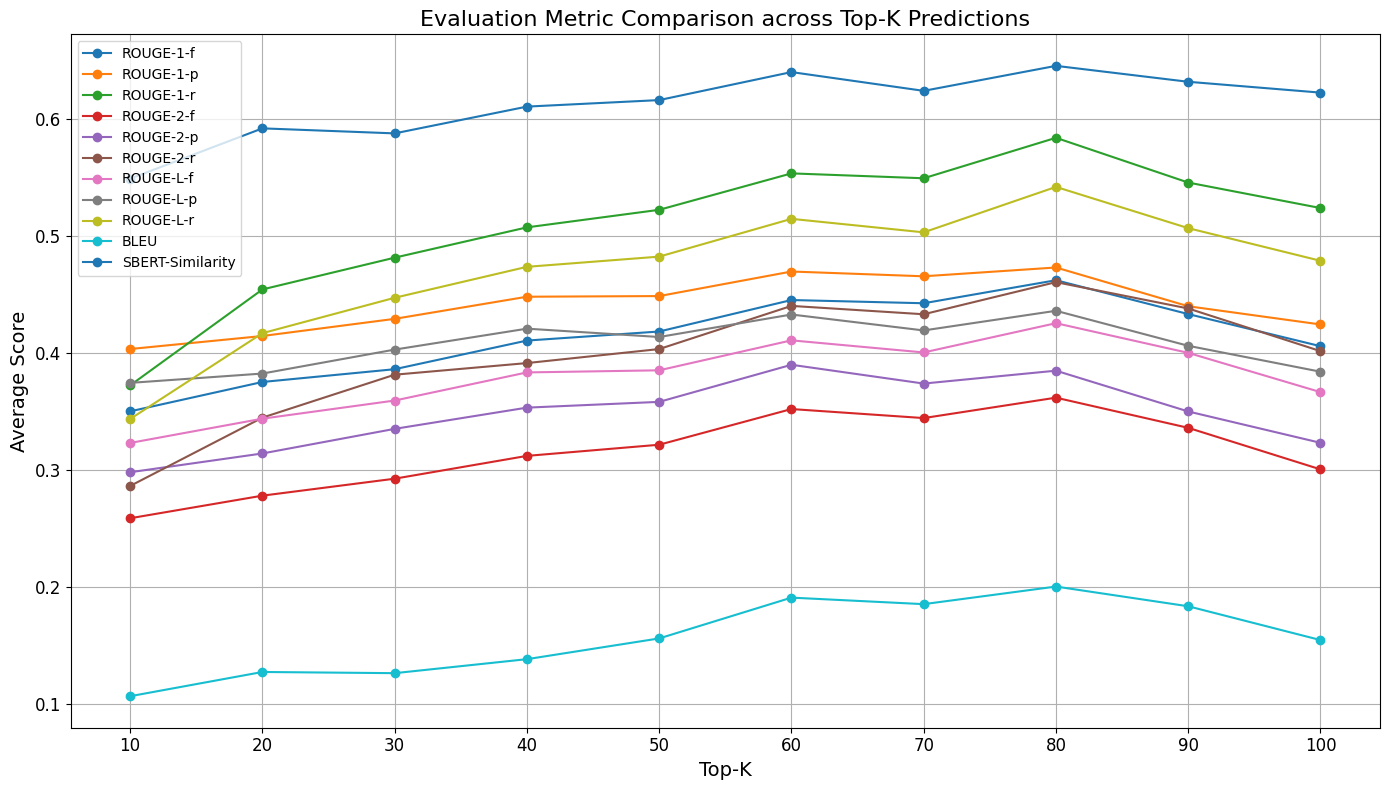

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer, util

# Initialization
rouge = Rouge()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
smoothing = SmoothingFunction().method1

# Configuration
base_path = "../data/MSE-KG/BGEM3/"
top_k_list = list(range(10, 101, 10))
results = {}

# Batch processing
for top_k in top_k_list:

    file_name = f"Predicted_Answers_Contexts_by_BGE_M3_Decom5_{top_k}.xlsx"
    file_path = os.path.join(base_path, file_name)
    
    if not os.path.exists(file_path):
        continue

    df = pd.read_excel(file_path)

    # Initialize metric columns
    for metric in [
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]:
        df[metric] = 0.0

    for i, row in df.iterrows():
        generated = str(row["Answer"])
        ground_truth = str(row["Ground Truth"])

        try:
            rouge_scores = rouge.get_scores(generated, ground_truth)[0]
            df.at[i, "ROUGE-1-f"] = rouge_scores["rouge-1"]["f"]
            df.at[i, "ROUGE-1-p"] = rouge_scores["rouge-1"]["p"]
            df.at[i, "ROUGE-1-r"] = rouge_scores["rouge-1"]["r"]
            df.at[i, "ROUGE-2-f"] = rouge_scores["rouge-2"]["f"]
            df.at[i, "ROUGE-2-p"] = rouge_scores["rouge-2"]["p"]
            df.at[i, "ROUGE-2-r"] = rouge_scores["rouge-2"]["r"]
            df.at[i, "ROUGE-L-f"] = rouge_scores["rouge-l"]["f"]
            df.at[i, "ROUGE-L-p"] = rouge_scores["rouge-l"]["p"]
            df.at[i, "ROUGE-L-r"] = rouge_scores["rouge-l"]["r"]
        except:
            continue

        try:
            bleu = sentence_bleu([ground_truth.split()], generated.split(), smoothing_function=smoothing)
            df.at[i, "BLEU"] = bleu
        except:
            df.at[i, "BLEU"] = 0.0

        try:
            emb_gt = sbert_model.encode(ground_truth, convert_to_tensor=True, show_progress_bar=False)
            emb_gen = sbert_model.encode(generated, convert_to_tensor=True, show_progress_bar=False)
            sim = util.pytorch_cos_sim(emb_gt, emb_gen).item()
            df.at[i, "SBERT-Similarity"] = sim
        except:
            df.at[i, "SBERT-Similarity"] = 0.0

    # Save evaluated results for each file
    evaluated_file = os.path.join(base_path, f"Evaluated_Predicted_Answers_Contexts_by_BGE_M3_Decom5_{top_k}.xlsx")
    df.to_excel(evaluated_file, index=False)

    # Calculate averages for summary
    avg_scores = df[[
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]].mean()
    results[top_k] = avg_scores.to_dict()

    # Plot for current topK
    plt.figure(figsize=(12, 6))
    avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Top-{top_k} Evaluation Metrics", fontsize=16)
    plt.ylabel("Average Score", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.close()

# Create summary table of averages
result_df = pd.DataFrame(results).T
result_df.index.name = "Top-K"
result_df.to_excel("../data/MSE-KG/BGEM3/Evaluation_Comparison_Averages_BGE_M3_Decom.xlsx")

# Plot comparison across all Top-K values
plt.figure(figsize=(14, 8))
for metric in result_df.columns:
    plt.plot(result_df.index, result_df[metric], marker='o', label=metric)

plt.title("Evaluation Metric Comparison across Top-K Predictions", fontsize=16)
plt.xlabel("Top-K", fontsize=14)
plt.ylabel("Average Score", fontsize=14)
plt.xticks(result_df.index, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/MSE-KG/BGEM3/Evaluation_Comparison_Averages_BGE_M3_Decom.png")
plt.show()